<a href="https://colab.research.google.com/github/tb000330/BPA_Lab/blob/main/Climate%20finance/%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B3%80%ED%98%95_%EB%B2%94%EC%9C%84_%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D(XGB_pannel_df).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
import datetime
from tqdm import tqdm

import seaborn as sns
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
plt.rc('font', family='NanumGothic')
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import TimeSeriesSplit 
from matplotlib.patches import Patch 

In [ ]:
panel = pd.read_csv('/content/drive/MyDrive/학교/연구 자료/기후금융/finance_data/panel_df.csv')
panel = panel.iloc[:,1:].reset_index(drop=True)
panel.tail(3)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (44,45) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,code,cor_name,Accounting_Closing,year,cash/assets,liabilities/assets,liabilities-cash/assets,sales/cur_liabilities,cur_assets/cur_liabilities,retained_earnings/cur_liabilities,...,코드대분류,코드세분류,코드세세분류,코드소분류,코드중분류,주거래은행,최초상장일자,상장일자,unlist_date,unlist_reason
111901,A950180,SNK,7.0,2019,0.817917,0.054197,-0.763720,7.171777,21.456253,6.256272,...,J,5821.0,5821.0,582.0,58.0,미츠호은행,20190507.0,20190507.0,2022-05-18,상장폐지 신청('22.04.14)
111902,A950180,SNK,7.0,2020,0.600422,0.065299,-0.535123,4.686278,17.116893,6.287657,...,J,5821.0,5821.0,582.0,58.0,미츠호은행,20190507.0,20190507.0,2022-05-18,상장폐지 신청('22.04.14)
111903,A950180,SNK,7.0,2021,0.694562,0.101859,-0.592702,2.830798,9.826040,1.322351,...,J,5821.0,5821.0,582.0,58.0,미츠호은행,20190507.0,20190507.0,2022-05-18,상장폐지 신청('22.04.14)


# #1. 전처리 & 파생변수

In [ ]:
panel = pd.read_csv('/content/drive/MyDrive/학교/연구 자료/기후금융/finance_data/panel_df.csv')
panel = panel.iloc[:,1:].reset_index(drop=True)

# return 변수 float
panel['return'] = panel['return'].astype(str)
panel['return'] = [re.sub(",", "", row) for row in panel['return']]
panel['return'] = panel['return'].astype(float)

# astype 또는 to_datetime로 변환
# panel['year'] = panel['year'].astype(str)
panel['최초상장일자'] = panel['최초상장일자'].astype(str)
panel['상장일자'] = panel['상장일자'].astype(str)
panel['최초상장일자'] = [re.sub(".0$", "", row) for row in panel['최초상장일자']]
panel['상장일자'] = [re.sub(".0$", "", row) for row in panel['상장일자']]
panel['최초상장일자'] = pd.to_datetime(panel['최초상장일자'])
panel['상장일자'] = pd.to_datetime(panel['상장일자'])

panel['unlist_year'] = panel['unlist_date'].str.slice(stop=4)
# panel['unlist_date'] = pd.to_datetime(panel['unlist_date'])
# panel['Accounting_Closing'] = panel['Accounting_Closing'].astype(int) #오류남
panel['unlist_reason'] = panel['unlist_reason'].astype(str)

# 금융회사 제외
panel = panel[panel['대분류']!='금융 및 보험업']
panel = panel.drop(['대분류', '세분류', '세세분류','소분류', '중분류', '코드세분류', '코드세세분류', '코드소분류', '코드중분류', '주거래은행'], axis=1)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (47,48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## (1) 재상장 여부 파생변수

In [ ]:
## 변수 중요도가 매우 적어서 drop

In [ ]:
# ## 재상장 여부 파생변수
# relist_list=[]

# for f,s in zip(panel['최초상장일자'], panel['상장일자']):
#   if f != s:
#     relist_list.append(True)
#   else:
#     relist_list.append(False)

# panel['relist'] = relist_list

# panel[panel['최초상장일자']!=panel['상장일자']][['최초상장일자','상장일자','relist']]

## (2) 상장폐지 사유 전처리 & 카테고리화

In [ ]:
panel['unlist_reason_ctg'] = panel['unlist_reason']

## 상장폐지신청 dict로 class화 
ctg_dict = {}
ctg_list = ['(상장폐지 ?신청)|(^신청)','(신청)|(요청)|(자진)',"(상장$)|(^시장)|(^증권)",'(편입)|(흡수)',"지주회사", "영업의 양도", "기타", "계약이전",
            '해산', "부도", '전액', '자본', "(^감사(으로)? ?의견( 의견)? ?거절)|(범위 ?제한)|(감사의견 ?부적정)|(감사의견거절)", "경영", 
            "(시가 ?총액)|(시총)","주식","보통주", "정리", "영업", "유예", "정지", "제출", "부진", "액면가", "불성실", "화의 불인가", "회생"]

for ctg in ctg_list:
  r = re.compile(ctg) 
  v = list(set([row for row in panel['unlist_reason_ctg'] if r.search(row) is not None]))
  k = min(v, key=len)
  ctg_dict[k] = v
  panel['unlist_reason_ctg'] = panel['unlist_reason_ctg'].replace(v, '0')

# keys 이름 수정
# ctg_dict["자본잠식률 50% 이상"] = ctg_dict["2회연속 자본잠식률 50%이상"]
# ctg_dict["불성실공시법인지정"] = ctg_dict["최근 2년간 3회이상 불성실공시법인으로 지정"]

# del ctg_dict["2회연속 자본잠식률 50%이상"], ctg_dict["최근 2년간 3회이상 불성실공시법인으로 지정"]

In [ ]:
ctg_dict.keys()

dict_keys(['신청에 의한 상장폐지', '자진등록취소', '증권거래소 상장', '피흡수합병', '지주회사(최대주주등)의 완전자회사화 등', '주된영업의 양도', '기타 등록취소', '계약이전', '해산 사유 발생', '부도', '자본전액잠식', '2회연속 자본잠식률 50%이상', '감사의견거절', '기업의 계속성 및 경영의 투명성 등을 종합적으로 고려하여 상장폐지기준에 해당', '시가총액 미달', '주식양도 제한', '보통주 주가수준미달', '회사정리절차 폐지 결정', '영업활동정지 6월 계속', '상장폐지유예기간종료', '당좌거래정지', '사업보고서 법정제출기한 익일부터 10일이내 미제출', '2분기 연속 거래실적부진사유 미해소', '액면가액일정비율 미달', '최근 2년간 3회이상 불성실공시법인으로 지정', '화의 불인가', '회생절차폐지결정사유 및 당해 코스닥시장상장법인의 계속기업 가능성 유무를 고려한 결과 상장폐지기준에 해당한다고 결정'])

In [ ]:
## dict로 replace
panel['unlist_reason_ctg'] = panel['unlist_reason']

# values에 해당되면 key로 치환
key_list = []

for reason in panel['unlist_reason_ctg']:
  key = [k for k, v in ctg_dict.items() if reason in v]
  if len(key)==0:
    key_list.extend(reason)
  else:
    key_list.extend(key)

panel['unlist_reason_ctg'] = key_list
panel[panel['unlist_reason_ctg']!=panel['unlist_reason']][['unlist_reason_ctg', 'unlist_reason']]

,unlist_reason_ctg,unlist_reason
76864,자본전액잠식,자본전액잠식 2년 계속
76865,자본전액잠식,자본전액잠식 2년 계속
76866,자본전액잠식,자본전액잠식 2년 계속
76867,자본전액잠식,자본전액잠식 2년 계속
76868,자본전액잠식,자본전액잠식 2년 계속
...,...,...
111899,신청에 의한 상장폐지,상장폐지 신청('22.04.14)
111900,신청에 의한 상장폐지,상장폐지 신청('22.04.14)
111901,신청에 의한 상장폐지,상장폐지 신청('22.04.14)
111902,신청에 의한 상장폐지,상장폐지 신청('22.04.14)


## (3) 재무부실 사유 상장폐지기업 class 파생변수

In [ ]:
## 재무적 이유로 상장폐지 하지 않은 사유 필터
panel['fnc_rsn_unlst'] = panel['unlist_reason_ctg']

panel['fnc_rsn_unlst'] = panel['fnc_rsn_unlst'].replace(['해산 사유 발생', '영업활동정지 6월 계속', '자본전액잠식', '회사정리절차 폐지 결정', 
                                                         '감사의견거절', '주식양도 제한', '상장폐지유예기간종료', '부도', 
                                                         '보고서 또는 서류 미제출', '자본잠식률 50% 이상', '시가총액 미달', '보통주 주가수준미달', 
                                                         '당좌거래정지', '액면가액일정비율 미달', '기업의 계속성 및 경영의 투명성 등을 종합적으로 고려하여 상장폐지기준에 해당',
                                                         '화의 불인가', '불성실공시법인지정', '2분기 연속 거래실적부진사유 미해소',
                                                         '회생절차폐지결정사유 및 당해 코스닥시장상장법인의 계속기업 가능성 유무를 고려한 결과 상장폐지기준에 해당한다고 결정'],"1")
panel['fnc_rsn_unlst'] = panel['fnc_rsn_unlst'].replace(['피흡수합병','자진등록취소','신청에 의한 상장폐지', '지주회사(최대주주등)의 완전자회사화 등',
                                                          '코스닥시장 상장', '기타 등록취소', '주된영업의 양도','계약이전'],"0")
panel[['unlist_reason_ctg', 'fnc_rsn_unlst']] # {상장폐지X, 그외사유 상장폐지: 0}, {재무사유 상장폐지: 1}

,unlist_reason_ctg,fnc_rsn_unlst
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
111899,신청에 의한 상장폐지,0
111900,신청에 의한 상장폐지,0
111901,신청에 의한 상장폐지,0
111902,신청에 의한 상장폐지,0


## (4) 기업코드 레이블 인코딩

In [ ]:
## 기업코드 레이블 인코딩
panel['code_label'] = [int(re.sub("^A", "", row) )for row in panel['code']]

In [ ]:
## 되돌리기 위한 매칭 함수 {기업코드_int:기업코드}
def df_to_dict(df, keys_col, values_col):
      
  trans = df.loc[:,[keys_col, values_col]].transpose()
  trans.columns = trans.iloc[0]
  trans = trans.iloc[1].to_dict()

  for k in list(trans.keys()):
    if pd.isnull(trans[k])==True:
      del trans[k]

  return trans

# code_dict = df_to_dict(panel, 'code_label','code')
# print(code_dict)

## (5) 결측치 제거 
- 재무정보columns('cash/assets':'retained_earning')이 모두 Nan값인 경우만 row drop
- 열 하나라도 Nan값이 아니라면 drop하지 않음
- 주가정보 제외하고 재무정보가 없으면

In [ ]:
panel = panel.dropna(subset = panel.loc[:,'cash/assets':'net_income_grow'].columns,axis = 0, how='all').reset_index(drop=True)
panel.apply(lambda x: pd.isna(x).sum()) 

code                                     0
cor_name                                 0
Accounting_Closing                       0
year                                     0
cash/assets                              6
liabilities/assets                       5
liabilities-cash/assets                  5
sales/cur_liabilities                    6
cur_assets/cur_liabilities               5
retained_earnings/cur_liabilities        6
non_cur_lia/non_cur_lia+worth            6
interest/cash_flow                      13
interest/ebitda                         23
inven/sales                            158
sales/net_income                        13
gross_margin/sales                     191
sales/retained_earnings                 15
change_in_roa                         9303
change_in_AR                          2896
change_in_TP                          4317
assets                                   5
sales                                    0
roa                                   4691
sales_grow 

In [ ]:
panel.shape

(55904, 44)

## (6) 상장폐지 날짜 class 형태 파생변수

### a. 상장폐지날짜 정보 기준 (panel_a)

In [ ]:
## 상장폐지일이 지난 후에도 재무정보가 있는 행 drop
panel['unlist_year'] = panel['unlist_year'].fillna(10000).astype(int)
panel_a = panel[panel['year']<=panel['unlist_year']].reset_index(drop=True) # year > unlist_year인 행 제외

In [ ]:
## 상장폐지일이 지난 후에 회계결산한 재무정보 행 drop (월이 같아도 회계결산은 월말에 이뤄지므로 같거나 회계결산월이 더 크면 drop)
panel_a['unlist_mon'] = panel_a['unlist_date'].str.slice(start=5, stop=7)
panel_a['unlist_mon'] = panel_a['unlist_mon'].fillna(10000).astype(float)
panel_a = panel_a[(panel_a['year']!=panel_a['unlist_year'])|((panel_a['year']==panel_a['unlist_year'])&(panel_a['Accounting_Closing']<panel_a['unlist_mon']))].reset_index(drop=True)
print(54920-220)
print(panel_a.shape)

54700
(54728, 45)


In [ ]:
## [선택]
### (1) 오직 전년도 재무정보를 가지고 다음해 상장폐지를 예측할 것인가? -> 아래 코드 필요 O
### (2) 상장폐지 당해 연도 재무정보가 반영되어 상장폐지가 결정된 경우도 고려할 것인가? (상장폐지 당해연도 재무정보 사용할 것인가?) -> 아래코드 필요X
print(54920-220-10)
# panel_a = panel_a[panel_a['year']!=panel_a['unlist_year']].reset_index(drop=True)
panel_a

54690


,code,cor_name,Accounting_Closing,year,cash/assets,liabilities/assets,liabilities-cash/assets,sales/cur_liabilities,cur_assets/cur_liabilities,retained_earnings/cur_liabilities,...,상장일자,unlist_date,unlist_reason,bsn_code,grngas,unlist_year,unlist_reason_ctg,fnc_rsn_unlst,code_label,unlist_mon
0,A005930,삼성전자,12.0,1990,0.026243,0.805812,0.779569,2.738511,0.948362,0.223232,...,1975-06-11,NaN,0,124-81-00998,NaN,10000,0,0,5930,10000.0
1,A005930,삼성전자,12.0,1991,0.011561,0.825602,0.814041,1.887630,0.740129,0.145565,...,1975-06-11,NaN,0,124-81-00998,NaN,10000,0,0,5930,10000.0
2,A005930,삼성전자,12.0,1992,0.026253,0.819760,0.793507,2.032037,0.708325,0.146367,...,1975-06-11,NaN,0,124-81-00998,NaN,10000,0,0,5930,10000.0
3,A005930,삼성전자,12.0,1993,0.033530,0.793795,0.760265,2.495139,0.815311,0.162677,...,1975-06-11,NaN,0,124-81-00998,NaN,10000,0,0,5930,10000.0
4,A005930,삼성전자,12.0,1994,0.022999,0.692778,0.669779,3.189266,1.128719,0.412265,...,1975-06-11,NaN,0,124-81-00998,NaN,10000,0,0,5930,10000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54723,A950180,SNK,7.0,2017,0.611887,0.168936,-0.442952,4.380337,5.477438,2.218058,...,2019-05-07,2022-05-18,상장폐지 신청('22.04.14),000-81-20024,NaN,2022,신청에 의한 상장폐지,0,950180,5.0
54724,A950180,SNK,7.0,2018,0.527099,0.165288,-0.361812,4.341584,6.356767,3.357695,...,2019-05-07,2022-05-18,상장폐지 신청('22.04.14),000-81-20024,NaN,2022,신청에 의한 상장폐지,0,950180,5.0
54725,A950180,SNK,7.0,2019,0.817917,0.054197,-0.763720,7.171777,21.456253,6.256272,...,2019-05-07,2022-05-18,상장폐지 신청('22.04.14),000-81-20024,NaN,2022,신청에 의한 상장폐지,0,950180,5.0
54726,A950180,SNK,7.0,2020,0.600422,0.065299,-0.535123,4.686278,17.116893,6.287657,...,2019-05-07,2022-05-18,상장폐지 신청('22.04.14),000-81-20024,NaN,2022,신청에 의한 상장폐지,0,950180,5.0


In [ ]:
## 위의 조건 drop후, 마지막 연도 재무정보에 라벨링 == '1'
panel_a['unlist_last_year'] = '0' 
unlist_cor = list(panel_a[panel_a['unlist_date'].notnull()]['cor_name'].unique())
fin_year_list=[]

for cor in unlist_cor:
  fin_year = max(list(panel_a[panel_a['cor_name']==cor]['year']))
  fin_idx = panel_a[(panel_a['cor_name']==cor)&(panel_a['year']==fin_year)].index
  panel_a['unlist_last_year'][fin_idx] = '1'

## 재무부실사유 상장폐지 아닌 기업 == 0
panel_a['fnc_rsn_unlst_year'] = panel_a['fnc_rsn_unlst']
panel_a['fnc_rsn_unlst_year']  = np.where((panel_a['fnc_rsn_unlst']=="1")&(panel_a['unlist_last_year']=="1"), "1", "0")

panel_a[panel_a['unlist_date'].notnull()][['cor_name', 'year','fnc_rsn_unlst','unlist_last_year','fnc_rsn_unlst_year','unlist_date']].tail(10)

<ipython-input-45-5c4f38002cc2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel_a['unlist_last_year'][fin_idx] = '1'


,cor_name,year,fnc_rsn_unlst,unlist_last_year,fnc_rsn_unlst_year,unlist_date
54718,중국고섬,2008,1,0,0,2013-10-04
54719,중국고섬,2009,1,0,0,2013-10-04
54720,중국고섬,2010,1,0,0,2013-10-04
54721,중국고섬,2011,1,0,0,2013-10-04
54722,중국고섬,2012,1,1,1,2013-10-04
54723,SNK,2017,0,0,0,2022-05-18
54724,SNK,2018,0,0,0,2022-05-18
54725,SNK,2019,0,0,0,2022-05-18
54726,SNK,2020,0,0,0,2022-05-18
54727,SNK,2021,0,1,0,2022-05-18


In [ ]:
## 순서 변경
panel_a = panel_a[['code', 'cor_name', 'Accounting_Closing', 'year', 'cash/assets', 'liabilities/assets', 'liabilities-cash/assets',
       'sales/cur_liabilities', 'cur_assets/cur_liabilities','retained_earnings/cur_liabilities', 'non_cur_lia/non_cur_lia+worth',
       'interest/cash_flow', 'interest/ebitda', 'inven/sales','sales/net_income', 'gross_margin/sales', 'sales/retained_earnings',
       'change_in_roa', 'change_in_AR', 'change_in_TP', 'assets', 'sales','roa', 'sales_grow', 'net_income', 'net_income_grow','gross_profit', 'operating_profit', 'retained_earning', 'closing_price',
       'revised_price', 'market_capital', 'return','code_label','fnc_rsn_unlst_year','코드대분류', '최초상장일자', '상장일자',
       'unlist_date', 'unlist_reason', 'unlist_year', 'unlist_reason_ctg', 'fnc_rsn_unlst', 'unlist_mon', 'unlist_last_year']]

### b. 폐지 결정 후 마지막 재무정보 기준 (panel_b)

In [ ]:
panel_b = panel.copy()

In [ ]:
## 상장폐지 후 마지막 재무정보에 라벨링
panel_b['unlist_last_year'] = '0' 
unlist_cor = list(panel_b[panel_b['unlist_date'].notnull()]['cor_name'].unique())
fin_year_list=[]

for cor in unlist_cor:
  fin_year = max(list(panel_b[panel_b['cor_name']==cor]['year']))
  fin_idx = panel_b[(panel_b['cor_name']==cor)&(panel_b['year']==fin_year)].index
  panel_b['unlist_last_year'][fin_idx] = '1'

## 재무부실사유 상장폐지 아닌 기업 == 0
panel_b['fnc_rsn_unlst_year'] = panel_b['fnc_rsn_unlst']
panel_b['fnc_rsn_unlst_year']  = np.where((panel_b['fnc_rsn_unlst']=="1")&(panel_b['unlist_last_year']=="1"), "1", "0")

panel_b[panel_b['unlist_date'].notnull()][['cor_name', 'year','fnc_rsn_unlst','unlist_last_year','fnc_rsn_unlst_year', 'unlist_date']].tail(10)

<ipython-input-48-301ba156e34e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel_b['unlist_last_year'][fin_idx] = '1'


,cor_name,year,fnc_rsn_unlst,unlist_last_year,fnc_rsn_unlst_year,unlist_date
55894,중국고섬,2008,1,0,0,2013-10-04
55895,중국고섬,2009,1,0,0,2013-10-04
55896,중국고섬,2010,1,0,0,2013-10-04
55897,중국고섬,2011,1,0,0,2013-10-04
55898,중국고섬,2012,1,1,1,2013-10-04
55899,SNK,2017,0,0,0,2022-05-18
55900,SNK,2018,0,0,0,2022-05-18
55901,SNK,2019,0,0,0,2022-05-18
55902,SNK,2020,0,0,0,2022-05-18
55903,SNK,2021,0,1,0,2022-05-18


In [ ]:
## 순서 변경
panel_b = panel_b[['code', 'cor_name', 'Accounting_Closing', 'year', 'cash/assets', 'liabilities/assets', 'liabilities-cash/assets',
       'sales/cur_liabilities', 'cur_assets/cur_liabilities','retained_earnings/cur_liabilities', 'non_cur_lia/non_cur_lia+worth',
       'interest/cash_flow', 'interest/ebitda', 'inven/sales','sales/net_income', 'gross_margin/sales', 'sales/retained_earnings',
       'change_in_roa', 'change_in_AR', 'change_in_TP', 'assets', 'sales','roa', 'sales_grow', 'net_income', 'net_income_grow','gross_profit', 'operating_profit', 'retained_earning' , 'closing_price',
       'revised_price', 'market_capital', 'return','code_label','fnc_rsn_unlst_year','코드대분류', '최초상장일자', '상장일자',
       'unlist_date', 'unlist_reason', 'unlist_year', 'unlist_reason_ctg', 'fnc_rsn_unlst', 'unlist_last_year']]

## (7) 다음 해에 상장폐지가 되었는지 유무에 대한 변수 [종속변수]

In [ ]:
## 필요X
def cor_shift(df, period):
  shift_result = pd.DataFrame()

  for cor in df['code_label'].unique():
    df_cor = df[df['code_label']==cor]
    df_cor['y_shift'] = df_cor['fnc_rsn_unlst_year'].shift(periods=period)
    shift_result = pd.concat([shift_result, df_cor], axis=0)

  return shift_result

# panel_shift = cor_shift(panel_a, 1)

# #2. 데이터 형태

- (1) 무지성 모든연도 때려넣기 (원데이터)
- (2) row -> col (원데이터)
- (3) 변화율 (변환)
- (4) 지수함수화, 최소자승법 (변환)

In [ ]:
def var1(df):
  X1 = df.loc[:,'cash/assets':'retained_earning']
  X1['year'] = df['year']
  X1['code_label'] = df['code_label']

  y = df['fnc_rsn_unlst_year']

  return X1, y

## (1) 원데이터: 직전 연도 재무정보로 다음 해 상장폐지 예측 

In [ ]:
def xgb_smltn(X, y):

  X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=1)

  # 객체 생성
  model = XGBClassifier(n_estimators=500, early_stopping_rounds=1, max_depth=3, random_state=0)
  xgb_model = model.fit(X_train, y_train, early_stopping_rounds=100,eval_set=[(X_test, y_test)])

  # 예측하기
  y_pre = xgb_model.predict(X_test)
  y_pred_probs = xgb_model.predict_proba(X_test)[:,1]

  # # 특성 중요도 시각화
  # fig, ax = plt.subplots(figsize=(10,12))
  # plot_importance(xgb_model, ax=ax)

  X_test['y_real'] = y_test
  X_test['y_pred'] = y_pre

  print("정확도:",accuracy_score(y_pre, y_test))

  return X_test

In [ ]:
X1_1, y1_1 = var1(panel_a)
result1_1 = xgb_smltn(X1_1, y1_1)

In [ ]:
print("정확도:",accuracy_score(result1_1['y_pred'], result1_1['y_real']))

정확도: 0.9901333820573726


In [ ]:
result_count = pd.DataFrame(result1_1.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
print(result1_1.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
print('상장폐지를 상장유지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
print('상장유지를 상장폐지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

y_real  y_pred
0       0         10831
        1             1
1       0           107
        1             7
Name: y_pred, dtype: int64 

상장폐지를 상장유지로 예측: 1 / 10832
상장유지를 상장폐지로 예측: 107 / 114
0.0001
0.9386


## (2) 원데이터: 특정 기간 연도의 재무정보를 하나의 row로 나열

In [ ]:
def train_row_to_col(df, contained_year):
  
  ## X
  X = pd.DataFrame()

  for cor in tqdm(df['code_label'].unique()):
    df_cor = df[df['code_label']==cor]

    if len(df_cor) >= contained_year:
      fin_year = max(list(df_cor['year']))
      fin_idx = df_cor[df_cor['year']==fin_year].index[0]
      df_cor = df_cor.loc[fin_idx-contained_year+1:fin_idx, 'cash/assets':'retained_earning']

      cor_result = pd.DataFrame()

      for row in df_cor.index:
        row_df = df_cor.loc[[row]].reset_index(drop=True)
        cor_result = pd.concat([cor_result, row_df], axis=1) #, names=[df_cor.columns for num in range(len(df_cor))])

      cor_result.columns = [col+'_'+str(num) for num in range(len(df_cor)) for col in df_cor.columns]
      cor_result['code_label'] = cor
      X = pd.concat([X, cor_result], ignore_index=True)
    else:
      pass

  ## y  
  y_list = []
  
  for row in tqdm(range(len(X))):
    row_cor_code = X['code_label'][row]
    fnc_unlst_cor = df[(df['code_label']==row_cor_code)&(df['fnc_rsn_unlst_year']=='1')]
    if len(fnc_unlst_cor)==1:
      y_list.append('1')
    elif len(fnc_unlst_cor)==0:
      y_list.append('0')
    else:
      print('error')
    
  X['fnc_rsn_unlst_year'] = y_list

  return X

train_data1 = train_row_to_col(panel_a, 3) #1년전 자료까지
train_data1

100%|██████████| 3015/3015 [00:15<00:00, 198.17it/s]


,cash/assets_0,liabilities/assets_0,liabilities-cash/assets_0,sales/cur_liabilities_0,cur_assets/cur_liabilities_0,retained_earnings/cur_liabilities_0,non_cur_lia/non_cur_lia+worth_0,interest/cash_flow_0,interest/ebitda_0,inven/sales_0,...,sales_2,roa_2,sales_grow_2,net_income_2,net_income_grow_2,gross_profit_2,operating_profit_2,retained_earning_2,code_label,fnc_rsn_unlst_year
0,0.076258,0.254376,0.178118,3.612275,2.843797,3.991406,0.089692,0.000000,0.000000,0.116173,...,2.796048e+11,9.92,18.07,3.990745e+10,51.120000,1.131935e+11,51.120000,2.930648e+11,5930,0
1,0.035343,0.265332,0.229989,3.389958,1.815833,5.391051,0.163224,0.023097,0.021645,0.196209,...,4.299779e+10,11.48,34.79,9.616188e+09,102.070000,1.895219e+10,102.070000,5.578407e+10,660,0
2,0.021162,0.263409,0.242247,1.016056,1.964158,2.480246,0.165993,0.076282,0.114032,0.644919,...,1.568007e+09,5.47,34.62,3.935895e+08,63.330000,7.264514e+08,63.330000,2.347187e+09,207940,0
3,0.058246,0.362267,0.304021,2.698748,1.384841,1.846005,0.214159,0.067770,0.062340,0.169144,...,1.355322e+10,5.28,20.00,1.250402e+09,98.170000,3.077618e+09,98.170000,8.516473e+09,6400,0
4,0.055508,0.489079,0.433571,3.059105,1.327483,1.655051,0.306947,0.000000,0.000000,0.184028,...,4.265472e+10,8.55,41.90,3.953904e+09,479.400000,1.121831e+10,479.400000,1.809195e+10,51910,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3010,0.158532,0.376612,0.218080,2.942309,1.858649,2.426290,0.234925,0.000000,0.000000,0.110994,...,1.726469e+08,3.94,-21.26,1.895981e+07,-13.720000,4.445221e+07,-13.720000,2.412923e+08,900180,1
3011,0.151074,0.240492,0.089417,2.045602,2.587493,1.616000,0.100846,-0.000000,-0.000000,0.115003,...,6.510070e+07,-15.25,-27.04,-1.111354e+08,120.455067,2.793654e+07,120.455067,-5.264892e+07,950010,1
3012,0.024121,0.635549,0.611428,1.704744,0.980736,0.429360,0.336886,0.008232,0.005724,0.039143,...,6.467582e+06,-61.04,-48.06,-1.396498e+07,3.281130,3.278447e+06,3.281130,-1.131896e+07,950030,1
3013,0.055200,0.417470,0.362270,3.955110,0.489901,0.445937,0.039451,-0.000000,0.000000,0.047236,...,8.769510e+07,-4.90,-12.82,-1.544306e+07,-0.584084,3.056754e+06,-0.584084,-9.833684e+07,950070,1


[0]	validation_0-error:0.140962
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.140962
[2]	validation_0-error:0.137645
[3]	validation_0-error:0.129353
[4]	validation_0-error:0.13267
[5]	validation_0-error:0.13267
[6]	validation_0-error:0.131012
[7]	validation_0-error:0.119403
[8]	validation_0-error:0.121061
[9]	validation_0-error:0.121061
[10]	validation_0-error:0.119403
[11]	validation_0-error:0.116086
[12]	validation_0-error:0.116086
[13]	validation_0-error:0.117745
[14]	validation_0-error:0.117745
[15]	validation_0-error:0.117745
[16]	validation_0-error:0.119403
[17]	validation_0-error:0.117745
[18]	validation_0-error:0.117745
[19]	validation_0-error:0.121061
[20]	validation_0-error:0.114428
[21]	validation_0-error:0.112769
[22]	validation_0-error:0.117745
[23]	validation_0-error:0.119403
[24]	validation_0-error:0.117745
[25]	validation_0-error:0.117745
[26]	validation_0-error:0.116086
[27]	validation_0-error:0.117745
[28]	validation_0-err

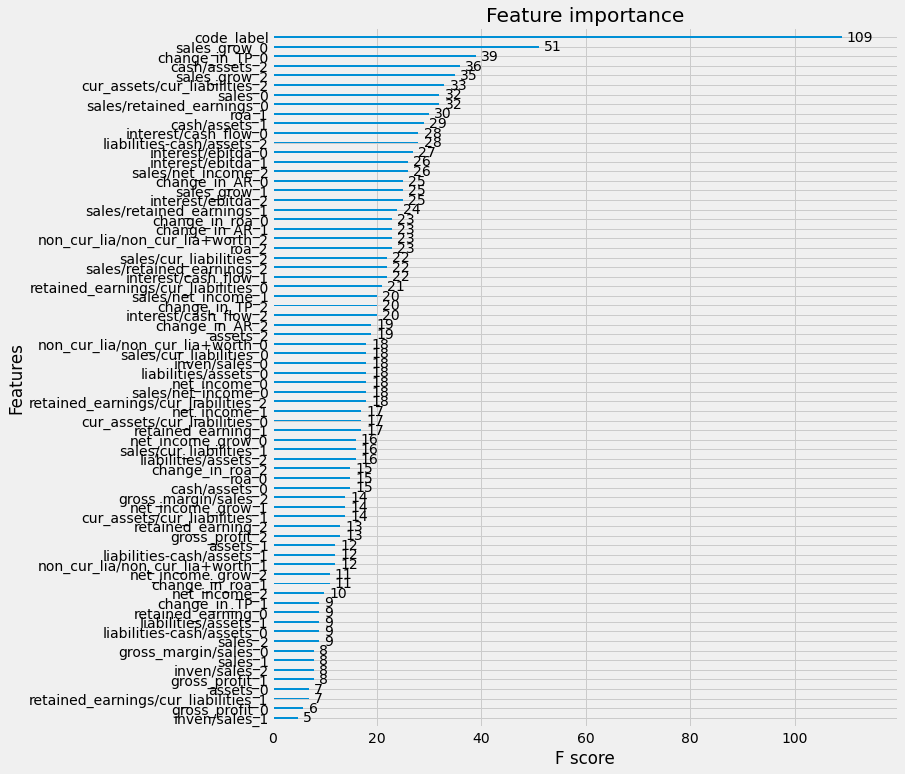

In [ ]:
X1_2 = train_data1.iloc[:,:-1]
y1_2 = train_data1['fnc_rsn_unlst_year']

result1_2 = xgb_smltn(X1_2, y1_2)

In [ ]:
print("정확도:",accuracy_score(result1_2['y_pred'], result1_2['y_real']))

정확도: 0.9038142620232172


In [ ]:
result_count = pd.DataFrame(result1_2.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
print(result1_2.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
print('상장폐지를 상장유지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
print('상장유지를 상장폐지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

y_real  y_pred
0       0         472
        1          18
1       0          40
        1          73
Name: y_pred, dtype: int64 

상장폐지를 상장유지로 예측: 18 / 490
상장유지를 상장폐지로 예측: 40 / 113
0.0367
0.354


## (3) 데이터 변환: 변화율, 증가율

In [ ]:
## ?. 변화율의 변화율 처리
panel_a.loc[:,'change_in_roa':'roa']

,change_in_roa,change_in_AR,change_in_TP,assets,sales,roa
0,-0.644068,0.376302,0.078972,4.057249e+09,4.511718e+09,2.10
1,-0.319048,0.217245,0.239576,5.551880e+09,5.227130e+09,1.43
2,-0.146853,-0.135195,-0.194717,6.326672e+09,6.102773e+09,1.22
3,-0.147541,-0.127702,-0.419701,8.447099e+09,8.684668e+09,1.04
4,9.682692,0.278744,-0.079209,9.603379e+09,1.176292e+10,11.11
...,...,...,...,...,...,...
54723,NaN,NaN,NaN,7.581997e+07,5.449621e+07,NaN
54724,NaN,0.027818,0.856271,1.049511e+08,6.791689e+07,27.48
54725,-0.467249,-0.211815,0.047309,3.209885e+08,1.020694e+08,14.64
54726,-0.542350,-0.183378,0.318245,3.557298e+08,8.600066e+07,6.70


In [ ]:
def growth_rate(p0, p1):
  rate = (p1 - p0)/p0 #증가율 계산 = (현재시점-이전시점)/(이전시점)
  return rate

In [ ]:
def train_growth_rate(df, contained_year): #마지막연도 재무정보 기준 n년 전
  
  ## X
  X = pd.DataFrame()

  for col in tqdm(df.columns[:-1]):
    rate_list = []
    cor_list = []

    for cor in df['code_label'].unique():
      df_cor = df[df['code_label']==cor][col].values

      if contained_year == 'all':
        p0 = df_cor[0]
        p1 = df_cor[-1]
      elif len(df_cor) > contained_year:
        p0 = df_cor[int(contained_year)-1]
        p1 = df_cor[-1]

      rate = growth_rate(p0, p1)

      cor_list.append(cor)
      rate_list.append(rate)

    X[col+'_'+'growth'] = rate_list

  X['code_label'] = cor_list
  X = X.drop(['code_label_growth'], axis=1)


  ## y  
  y_list = []
  
  for row in tqdm(range(len(X))):
    row_cor_code = X['code_label'][row]
    fnc_unlst_cor = df[(df['code_label']==row_cor_code)&(df['fnc_rsn_unlst_year']=='1')]
    if len(fnc_unlst_cor)==1:
      y_list.append('1')
    elif len(fnc_unlst_cor)==0:
      y_list.append('0')
    else:
      print('error')
    
  X['fnc_rsn_unlst_year'] = y_list

  return X

train_data1_3 = train_growth_rate(panel_a.loc[:,'cash/assets':'fnc_rsn_unlst_year'], 'all')  

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-39-70b133b319d3>:2: RuntimeWarning: divide by zero encountered in double_scalars
  rate = (p1 - p0)/p0 #증가율 계산 = (현재시점-이전시점)/(이전시점)
<ipython-input-39-70b133b319d3>:2: RuntimeWarning: invalid value encountered in double_scalars
  rate = (p1 - p0)/p0 #증가율 계산 = (현재시점-이전시점)/(이전시점)
100%|██████████| 3047/3047 [00:15<00:00, 193.36it/s]


[0]	validation_0-error:0.147541
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.144262
[2]	validation_0-error:0.140984
[3]	validation_0-error:0.137705
[4]	validation_0-error:0.137705
[5]	validation_0-error:0.139344
[6]	validation_0-error:0.144262
[7]	validation_0-error:0.134426
[8]	validation_0-error:0.131148
[9]	validation_0-error:0.131148
[10]	validation_0-error:0.134426
[11]	validation_0-error:0.136066
[12]	validation_0-error:0.132787
[13]	validation_0-error:0.131148
[14]	validation_0-error:0.134426
[15]	validation_0-error:0.136066
[16]	validation_0-error:0.129508
[17]	validation_0-error:0.132787
[18]	validation_0-error:0.132787
[19]	validation_0-error:0.132787
[20]	validation_0-error:0.132787
[21]	validation_0-error:0.131148
[22]	validation_0-error:0.132787
[23]	validation_0-error:0.132787
[24]	validation_0-error:0.132787
[25]	validation_0-error:0.132787
[26]	validation_0-error:0.132787
[27]	validation_0-error:0.132787
[28]	validation_0-e

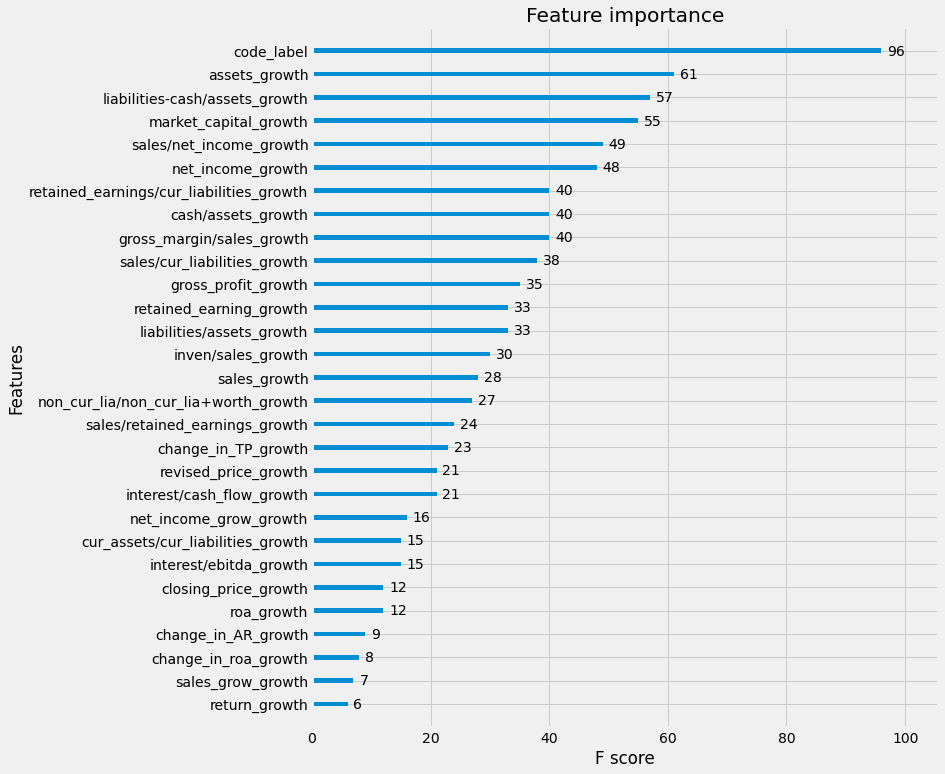

In [ ]:
X1_3 = train_data1_3.iloc[:,:-1]
y1_3 = train_data1_3['fnc_rsn_unlst_year']

result1_3 = xgb_smltn(X1_3, y1_3)

In [ ]:
print("정확도:",accuracy_score(result1_3['y_pred'], result1_3['y_real']))

정확도: 0.8737704918032787


In [ ]:
result_count = pd.DataFrame(result1_3.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
print(result1_3.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
print('상장폐지를 상장유지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
print('상장유지를 상장폐지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

y_real  y_pred
0       0         472
        1          32
1       0          45
        1          61
Name: y_pred, dtype: int64 

상장폐지를 상장유지로 예측: 32 / 504
상장유지를 상장폐지로 예측: 45 / 106
0.0635
0.4245


## (4) 데이터 변환: 최소제곱법 기반 지수함수 기울기

In [ ]:
def non_linear_least_square(x,Y):
    b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
    A = np.mean(Y)-np.mean(x)*b
    a = np.exp(A)
    return a,b

In [ ]:
def train_non_linear(df, contained_year):
  
  ## X
  X = pd.DataFrame()

  for col in tqdm(df.columns[:-1]):
    a_list = []
    b_list = []
    cor_list = []

    for cor in df['code_label'].unique():
      df_cor = df[df['code_label']==cor][col]

      if contained_year == 'all':
        y = df[df['code_label']==cor][col].values
      elif len(df_cor) >= contained_year:
        y = df_cor.iloc[len(df_cor)-contained_year:len(df_cor)].values

      x = np.array([inx for inx in range(len(y))])
      Y = np.log(y)

      a,b = non_linear_least_square(x,Y)

      cor_list.append(cor)
      a_list.append(a)
      b_list.append(b)

    X[col+'_'+'a'] = a_list
    X[col+'_'+'b'] = b_list

  X['code_label'] = cor_list
  X = X.drop(['code_label_a',	'code_label_b'], axis=1)


  ## y  
  y_list = []
  
  for row in tqdm(range(len(X))):
    row_cor_code = X['code_label'][row]
    fnc_unlst_cor = df[(df['code_label']==row_cor_code)&(df['fnc_rsn_unlst_year']=='1')]
    if len(fnc_unlst_cor)==1:
      y_list.append('1')
    elif len(fnc_unlst_cor)==0:
      y_list.append('0')
    else:
      print('error')
    
  X['fnc_rsn_unlst_year'] = y_list

  return X

train_data1_4 = train_non_linear(panel_a.loc[:,'cash/assets':'fnc_rsn_unlst_year'], 'all')  # 각 기업별 전범위는 contained_year='all'

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-56-c1bea963c831>:20: RuntimeWarning: divide by zero encountered in log
  Y = np.log(y)
<ipython-input-54-77dc735660f7>:2: RuntimeWarning: invalid value encountered in double_scalars
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-54-77dc735660f7>:2: RuntimeWarning: invalid value encountered in multiply
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-56-c1bea963c831>:20: RuntimeWarning: invalid value encountered in log
  Y = np.log(y)
100%|██████████| 3047/3047 [00:15<00:00, 194.44it/s]


In [ ]:
X1_4 = train_data1_4.iloc[:,:-1]
y1_4 = train_data1_4['fnc_rsn_unlst_year']

result1_4 = xgb_smltn(X1_4, y1_4)

In [ ]:
print("정확도:",accuracy_score(result1_4['y_pred'], result1_4['y_real']))

정확도: 0.8885245901639345


In [ ]:
result_count = pd.DataFrame(result1_4.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
print(result1_4.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
print('상장폐지를 상장유지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
print('상장유지를 상장폐지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

y_real  y_pred
0       0         473
        1          31
1       0          37
        1          69
Name: y_pred, dtype: int64 

상장폐지를 상장유지로 예측: 31 / 504
상장유지를 상장폐지로 예측: 37 / 106
0.0615
0.3491


# #3. 데이터 범위
- $X_t \; ←predict- \; X_{t-s} \quad (if \;\, s>1)$
- 몇 년도까지의 재무정보를 포함시켜야 가장 예측성능이 뛰어난가? 

  - 마지막 연도 회계정보만 (원데이터)
  - 마지막 연도 + (1년전 ㅣ2년전 | .. | n년도까지)
- 무조건 연도범위를 넓힌다고 성능향상X $ \to $ 기업별로 사업유지기간이 다르므로, 사업연도가 길어질수록 학습할 기업 감소(장기사업유지 기업 적음)

## (1) 원데이터 사용해 최적범위 탐색: 마지막 회계결산 재무정보로만 예측 
- 각 기업별 row는 마지막 재무정보로만 train 
- '데이터 범위(2)'에서 range(0)인 경우와 같음

In [ ]:
def train_last_fnc(df):
  train = pd.DataFrame()

  for cor in tqdm(df['code_label'].unique()):
    df_cor = df[df['code_label']==cor]

    fin_year = max(list(df_cor['year']))
    fin_idx = df_cor[df_cor['year']==fin_year]
    train = train.append(fin_idx)

  return train.reset_index(drop=True)

last_fnc_train = train_last_fnc(panel_a)

100%|██████████| 3047/3047 [00:12<00:00, 244.99it/s]


In [ ]:
last_fnc_train.head(3)

,code,cor_name,Accounting_Closing,year,cash/assets,liabilities/assets,liabilities-cash/assets,sales/cur_liabilities,cur_assets/cur_liabilities,retained_earnings/cur_liabilities,...,코드대분류,최초상장일자,상장일자,unlist_date,unlist_reason,unlist_year,unlist_reason_ctg,fnc_rsn_unlst,unlist_mon,unlist_last_year
0,A005930,삼성전자,12.0,2021,0.091490,0.285315,0.193825,3.173104,2.475832,3.325854,...,C,1975-06-11,1975-06-11,NaN,0,10000,0,0,10000.0,0
1,A373220,LG에너지솔루션,12.0,2021,0.053984,0.632119,0.578135,1.884302,1.006524,0.035633,...,C,2022-01-27,2022-01-27,NaN,0,10000,0,0,10000.0,0
2,A000660,SK하이닉스,12.0,2021,0.052476,0.354774,0.302298,2.911284,1.819338,3.777014,...,C,1996-12-26,1996-12-26,NaN,0,10000,0,0,10000.0,0


In [ ]:
X2_1, y2_1 = var1(last_fnc_train)
last_fnc_result1 = xgb_smltn(X2_1, y2_1)

In [ ]:
print("정확도:",accuracy_score(last_fnc_result1['y_pred'], last_fnc_result1['y_real']))

정확도: 0.9295081967213115


In [ ]:
result_count = pd.DataFrame(last_fnc_result1.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
print(last_fnc_result1.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
print('상장폐지를 상장유지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
print('상장유지를 상장폐지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

y_real  y_pred
0       0         466
        1          38
1       0           5
        1         101
Name: y_pred, dtype: int64 

상장폐지를 상장유지로 예측: 38 / 504
상장유지를 상장폐지로 예측: 5 / 106
0.0754
0.0472


## (2) 원데이터 사용해 최적범위 탐색: row로 나열하는 기간을 {마지막 연도 + (1년전ㅣ2년전 | .. | n년도까지)}
- '최대 길이연도까지'는 32로 총 92개의 기업이 장기적으로 사업한 기업개수가 매우 적고, 92개 기업 모두 상장폐지되지 않았으므로 결과가 무의미하게 나타남 $\to$ 실험X
- '최소 길이연도까지'는 1년이므로 결과가 무의미함 $\to$ 실험X

In [ ]:
result_score3_2 = pd.DataFrame()
term_list = []
score_list = []
list_0 = []
list_1 = []

for i in range(2, 8):
  term_list.append(str(i-1)+'년전까지')
  train_data3_2 = train_row_to_col(panel_a, i) # i = 마지막연도+ n년전 자료까지
  train_data3_2

  X3_2 = train_data3_2.iloc[:,:-1]
  y3_2 = train_data3_2['fnc_rsn_unlst_year']

  result3_2 = xgb_smltn(X3_2, y3_2)
  # try:
  #   result3_2 = xgb_smltn(X3_2, y3_2)
  # except:
  #   break
  #   print("the resulting train set will be empty. 0이상 "+str(i)+"이하로 설정하세요.")

  ## 정확도
  score = accuracy_score(result3_2['y_pred'], result3_2['y_real'])
  score_list.append(round(score,4))

  ## 오답 개수
  cnt = result3_2.groupby(['y_real','y_pred'])[['y_pred']].count()
  whole0_cnt = cnt.loc[('0','0'),('y_pred')] + cnt.loc[('0','1'),('y_pred')]
  wrng0_cnt = cnt.loc[('0','1'),('y_pred')]
  list_0.append(round((wrng0_cnt/whole0_cnt)*100, 3))

  whole1_cnt = cnt.loc[('1','0'),('y_pred')] + cnt.loc[('1','1'),('y_pred')]
  wrng1_cnt = cnt.loc[('1','0'),('y_pred')]
  list_1.append(round((wrng1_cnt/whole1_cnt)*100, 3))

result_score3_2['term'] = term_list
result_score3_2['score'] = score_list
result_score3_2['real0_pred1(%)'] = list_0
result_score3_2['real1_pred0(%)'] = list_1

In [ ]:
result_score3_2

,term,score,real0_pred1(%),real1_pred0(%)
0,1년전까지,0.9191,4.322,27.835
1,2년전까지,0.9104,5.389,26.471
2,3년전까지,0.9027,6.275,26.471
3,4년전까지,0.9043,5.179,36.145
4,5년전까지,0.9011,5.819,28.431
5,6년전까지,0.9016,4.646,34.021


## (3) 변화율 데이터 사용해 최적범위 탐색: 마지막 연도 + (1년전ㅣ2년전 | .. | n년도까지)
- 변화율이므로 (마지막 연도 + 이전 n년)이 필수

In [ ]:
result_score3_3 = pd.DataFrame()
term_list = []
score_list = []
list_0 = []
list_1 = []

for i in range(1, 8):
  term_list.append(str(i)+'년전까지')
  train_data3_3 = train_growth_rate(panel_a.loc[:,'cash/assets':'fnc_rsn_unlst_year'], i)     # i = 마지막연도 재무정보 기준 n년 전
  train_data3_3

  X3_3 = train_data3_3.iloc[:,:-1]
  y3_3 = train_data3_3['fnc_rsn_unlst_year']

  result3_3 = xgb_smltn(X3_3, y3_3)
  # try:
  #   result3_3 = xgb_smltn(X3_3, y3_3)
  # except:
  #   break
  #   print("the resulting train set will be empty. 0이상 "+str(i)+"이하로 설정하세요.")

  ## 정확도
  score = accuracy_score(result3_3['y_pred'], result3_3['y_real'])
  score_list.append(round(score,4))

  ## 오답 개수
  cnt = result3_3.groupby(['y_real','y_pred'])[['y_pred']].count()
  whole0_cnt = cnt.loc[('0','0'),('y_pred')] + cnt.loc[('0','1'),('y_pred')]
  wrng0_cnt = cnt.loc[('0','1'),('y_pred')]
  list_0.append(round((wrng0_cnt/whole0_cnt)*100, 3))

  whole1_cnt = cnt.loc[('1','0'),('y_pred')] + cnt.loc[('1','1'),('y_pred')]
  wrng1_cnt = cnt.loc[('1','0'),('y_pred')]
  list_1.append(round((wrng1_cnt/whole1_cnt)*100, 3))

result_score3_3['term'] = term_list
result_score3_3['score'] = score_list
result_score3_3['real0_pred1(%)'] = list_0
result_score3_3['real1_pred0(%)'] = list_1

In [ ]:
result_score3_3

,term,score,real0_pred1(%),real1_pred0(%)
0,1년전까지,0.9048,3.953,36.893
1,2년전까지,0.9064,3.953,35.922
2,3년전까지,0.9064,5.138,30.097
3,4년전까지,0.9080,4.941,30.097
4,5년전까지,0.9097,4.150,33.010
5,6년전까지,0.9064,4.545,33.010
6,7년전까지,0.9031,4.941,33.010


## (4) 지수함수 기울기 데이터 사용해 최적범위 탐색: 마지막 연도 + (1년전ㅣ2년전 | .. | n년도까지)

  0%|          | 0/27 [00:00<?, ?it/s]<ipython-input-44-77dc735660f7>:2: RuntimeWarning: invalid value encountered in double_scalars
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-45-c1bea963c831>:20: RuntimeWarning: divide by zero encountered in log
  Y = np.log(y)
<ipython-input-44-77dc735660f7>:2: RuntimeWarning: invalid value encountered in multiply
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-45-c1bea963c831>:20: RuntimeWarning: invalid value encountered in log
  Y = np.log(y)
100%|██████████| 3045/3045 [00:16<00:00, 189.42it/s]

[0]	validation_0-error:0.174056
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.174056
[2]	validation_0-error:0.16913
[3]	validation_0-error:0.16913
[4]	validation_0-error:0.174056
[5]	validation_0-error:0.174056
[6]	validation_0-error:0.174056
[7]	validation_0-error:0.174056
[8]	validation_0-error:0.174056
[9]	validation_0-error:0.16913
[10]	validation_0-error:0.174056
[11]	validation_0-error:0.174056
[12]	validation_0-error:0.174056
[13]	validation_0-error:0.174056


[14]	validation_0-error:0.174056
[15]	validation_0-error:0.16913
[16]	validation_0-error:0.16913
[17]	validation_0-error:0.16913
[18]	validation_0-error:0.174056
[19]	validation_0-error:0.174056
[20]	validation_0-error:0.174056
[21]	validation_0-error:0.174056
[22]	validation_0-error:0.174056
[23]	validation_0-error:0.174056
[24]	validation_0-error:0.174056
[25]	validation_0-error:0.174056
[26]	validation_0-error:0.174056
[27]	validation_0-error:0.174056
[28]	validation_0-error:0.174056
[29]	validation_0-error:0.174056
[30]	validation_0-error:0.174056
[31]	validation_0-error:0.174056
[32]	validation_0-error:0.174056
[33]	validation_0-error:0.174056
[34]	validation_0-error:0.174056
[35]	validation_0-error:0.174056
[36]	validation_0-error:0.174056
[37]	validation_0-error:0.174056
[38]	validation_0-error:0.174056
[39]	validation_0-error:0.174056
[40]	validation_0-error:0.174056
[41]	validation_0-error:0.174056
[42]	validation_0-error:0.174056
[43]	validation_0-error:0.174056
[44]	validati

  0%|          | 0/27 [00:00<?, ?it/s]<ipython-input-45-c1bea963c831>:20: RuntimeWarning: divide by zero encountered in log
  Y = np.log(y)
<ipython-input-44-77dc735660f7>:2: RuntimeWarning: invalid value encountered in double_scalars
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-44-77dc735660f7>:2: RuntimeWarning: invalid value encountered in multiply
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-45-c1bea963c831>:20: RuntimeWarning: invalid value encountered in log
  Y = np.log(y)
100%|██████████| 3045/3045 [00:18<00:00, 162.81it/s]

[0]	validation_0-error:0.108374
Will train until validation_0-error hasn't improved in 100 rounds.


[1]	validation_0-error:0.110016
[2]	validation_0-error:0.111658
[3]	validation_0-error:0.103448
[4]	validation_0-error:0.101806
[5]	validation_0-error:0.103448
[6]	validation_0-error:0.10509
[7]	validation_0-error:0.101806
[8]	validation_0-error:0.103448
[9]	validation_0-error:0.09688
[10]	validation_0-error:0.100164
[11]	validation_0-error:0.09688
[12]	validation_0-error:0.100164
[13]	validation_0-error:0.09688
[14]	validation_0-error:0.103448
[15]	validation_0-error:0.101806
[16]	validation_0-error:0.103448
[17]	validation_0-error:0.10509
[18]	validation_0-error:0.106732
[19]	validation_0-error:0.106732
[20]	validation_0-error:0.10509
[21]	validation_0-error:0.101806
[22]	validation_0-error:0.106732
[23]	validation_0-error:0.103448
[24]	validation_0-error:0.10509
[25]	validation_0-error:0.10509
[26]	validation_0-error:0.10509
[27]	validation_0-error:0.103448
[28]	validation_0-error:0.103448
[29]	validation_0-error:0.103448
[30]	validation_0-error:0.101806
[31]	validation_0-error:0.10

  0%|          | 0/27 [00:00<?, ?it/s]<ipython-input-45-c1bea963c831>:20: RuntimeWarning: divide by zero encountered in log
  Y = np.log(y)
<ipython-input-44-77dc735660f7>:2: RuntimeWarning: invalid value encountered in multiply
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-44-77dc735660f7>:2: RuntimeWarning: invalid value encountered in double_scalars
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-45-c1bea963c831>:20: RuntimeWarning: invalid value encountered in log
  Y = np.log(y)
100%|██████████| 3045/3045 [00:16<00:00, 186.69it/s]


[0]	validation_0-error:0.110016
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.1133
[2]	validation_0-error:0.110016
[3]	validation_0-error:0.103448
[4]	validation_0-error:0.10509
[5]	validation_0-error:0.10509
[6]	validation_0-error:0.101806
[7]	validation_0-error:0.10509
[8]	validation_0-error:0.103448
[9]	validation_0-error:0.10509
[10]	validation_0-error:0.098522
[11]	validation_0-error:0.098522
[12]	validation_0-error:0.100164
[13]	validation_0-error:0.098522
[14]	validation_0-error:0.093596
[15]	validation_0-error:0.095238
[16]	validation_0-error:0.095238
[17]	validation_0-error:0.095238
[18]	validation_0-error:0.098522
[19]	validation_0-error:0.093596
[20]	validation_0-error:0.091954
[21]	validation_0-error:0.093596
[22]	validation_0-error:0.093596
[23]	validation_0-error:0.091954
[24]	validation_0-error:0.087028
[25]	validation_0-error:0.08867
[26]	validation_0-error:0.090312
[27]	validation_0-error:0.08867
[28]	validation_0-error:0.0

  0%|          | 0/27 [00:00<?, ?it/s]<ipython-input-45-c1bea963c831>:20: RuntimeWarning: divide by zero encountered in log
  Y = np.log(y)
<ipython-input-44-77dc735660f7>:2: RuntimeWarning: invalid value encountered in double_scalars
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-44-77dc735660f7>:2: RuntimeWarning: invalid value encountered in multiply
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-45-c1bea963c831>:20: RuntimeWarning: invalid value encountered in log
  Y = np.log(y)
100%|██████████| 3045/3045 [00:16<00:00, 189.31it/s]

[0]	validation_0-error:0.118227
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.121511
[2]	validation_0-error:0.116585
[3]	validation_0-error:0.114943
[4]	validation_0-error:0.116585


[5]	validation_0-error:0.116585
[6]	validation_0-error:0.114943
[7]	validation_0-error:0.114943
[8]	validation_0-error:0.111658
[9]	validation_0-error:0.110016
[10]	validation_0-error:0.10509
[11]	validation_0-error:0.110016
[12]	validation_0-error:0.108374
[13]	validation_0-error:0.108374
[14]	validation_0-error:0.100164
[15]	validation_0-error:0.100164
[16]	validation_0-error:0.100164
[17]	validation_0-error:0.101806
[18]	validation_0-error:0.095238
[19]	validation_0-error:0.101806
[20]	validation_0-error:0.101806
[21]	validation_0-error:0.103448
[22]	validation_0-error:0.100164
[23]	validation_0-error:0.101806
[24]	validation_0-error:0.098522
[25]	validation_0-error:0.09688
[26]	validation_0-error:0.09688
[27]	validation_0-error:0.09688
[28]	validation_0-error:0.095238
[29]	validation_0-error:0.093596
[30]	validation_0-error:0.093596
[31]	validation_0-error:0.098522
[32]	validation_0-error:0.09688
[33]	validation_0-error:0.095238
[34]	validation_0-error:0.09688
[35]	validation_0-err

  0%|          | 0/27 [00:00<?, ?it/s]<ipython-input-45-c1bea963c831>:20: RuntimeWarning: divide by zero encountered in log
  Y = np.log(y)
<ipython-input-44-77dc735660f7>:2: RuntimeWarning: invalid value encountered in double_scalars
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-44-77dc735660f7>:2: RuntimeWarning: invalid value encountered in multiply
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-45-c1bea963c831>:20: RuntimeWarning: invalid value encountered in log
  Y = np.log(y)
100%|██████████| 3045/3045 [00:16<00:00, 187.87it/s]


[0]	validation_0-error:0.128079
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.128079
[2]	validation_0-error:0.123153
[3]	validation_0-error:0.126437
[4]	validation_0-error:0.126437
[5]	validation_0-error:0.124795
[6]	validation_0-error:0.119869
[7]	validation_0-error:0.119869
[8]	validation_0-error:0.116585
[9]	validation_0-error:0.111658
[10]	validation_0-error:0.110016
[11]	validation_0-error:0.111658
[12]	validation_0-error:0.114943
[13]	validation_0-error:0.111658
[14]	validation_0-error:0.1133
[15]	validation_0-error:0.111658
[16]	validation_0-error:0.110016
[17]	validation_0-error:0.111658
[18]	validation_0-error:0.108374
[19]	validation_0-error:0.110016
[20]	validation_0-error:0.110016
[21]	validation_0-error:0.106732
[22]	validation_0-error:0.10509
[23]	validation_0-error:0.10509
[24]	validation_0-error:0.103448
[25]	validation_0-error:0.103448
[26]	validation_0-error:0.101806
[27]	validation_0-error:0.10509
[28]	validation_0-error:

  0%|          | 0/27 [00:00<?, ?it/s]<ipython-input-45-c1bea963c831>:20: RuntimeWarning: divide by zero encountered in log
  Y = np.log(y)
<ipython-input-44-77dc735660f7>:2: RuntimeWarning: invalid value encountered in double_scalars
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-44-77dc735660f7>:2: RuntimeWarning: invalid value encountered in multiply
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-45-c1bea963c831>:20: RuntimeWarning: invalid value encountered in log
  Y = np.log(y)
100%|██████████| 3045/3045 [00:16<00:00, 187.44it/s]

[0]	validation_0-error:0.116585
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.123153


[2]	validation_0-error:0.129721
[3]	validation_0-error:0.124795
[4]	validation_0-error:0.128079
[5]	validation_0-error:0.123153
[6]	validation_0-error:0.114943
[7]	validation_0-error:0.114943
[8]	validation_0-error:0.114943
[9]	validation_0-error:0.118227
[10]	validation_0-error:0.116585
[11]	validation_0-error:0.116585
[12]	validation_0-error:0.114943
[13]	validation_0-error:0.114943
[14]	validation_0-error:0.114943
[15]	validation_0-error:0.114943
[16]	validation_0-error:0.108374
[17]	validation_0-error:0.110016
[18]	validation_0-error:0.108374
[19]	validation_0-error:0.110016
[20]	validation_0-error:0.108374
[21]	validation_0-error:0.106732
[22]	validation_0-error:0.108374
[23]	validation_0-error:0.110016
[24]	validation_0-error:0.111658
[25]	validation_0-error:0.108374
[26]	validation_0-error:0.110016
[27]	validation_0-error:0.108374
[28]	validation_0-error:0.108374
[29]	validation_0-error:0.106732
[30]	validation_0-error:0.108374
[31]	validation_0-error:0.10509
[32]	validation_0-e

  0%|          | 0/27 [00:00<?, ?it/s]<ipython-input-45-c1bea963c831>:20: RuntimeWarning: divide by zero encountered in log
  Y = np.log(y)
<ipython-input-44-77dc735660f7>:2: RuntimeWarning: invalid value encountered in double_scalars
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-44-77dc735660f7>:2: RuntimeWarning: invalid value encountered in multiply
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-45-c1bea963c831>:20: RuntimeWarning: invalid value encountered in log
  Y = np.log(y)
100%|██████████| 3045/3045 [00:18<00:00, 164.91it/s]

[0]	validation_0-error:0.129721
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.124795
[2]	validation_0-error:0.118227
[3]	validation_0-error:0.124795
[4]	validation_0-error:0.118227


[5]	validation_0-error:0.118227
[6]	validation_0-error:0.1133
[7]	validation_0-error:0.1133
[8]	validation_0-error:0.1133
[9]	validation_0-error:0.106732
[10]	validation_0-error:0.1133
[11]	validation_0-error:0.110016
[12]	validation_0-error:0.10509
[13]	validation_0-error:0.114943
[14]	validation_0-error:0.110016
[15]	validation_0-error:0.110016
[16]	validation_0-error:0.110016
[17]	validation_0-error:0.108374
[18]	validation_0-error:0.111658
[19]	validation_0-error:0.110016
[20]	validation_0-error:0.106732
[21]	validation_0-error:0.114943
[22]	validation_0-error:0.110016
[23]	validation_0-error:0.108374
[24]	validation_0-error:0.106732
[25]	validation_0-error:0.10509
[26]	validation_0-error:0.1133
[27]	validation_0-error:0.111658
[28]	validation_0-error:0.106732
[29]	validation_0-error:0.108374
[30]	validation_0-error:0.103448
[31]	validation_0-error:0.103448
[32]	validation_0-error:0.103448
[33]	validation_0-error:0.103448
[34]	validation_0-error:0.10509
[35]	validation_0-error:0.10

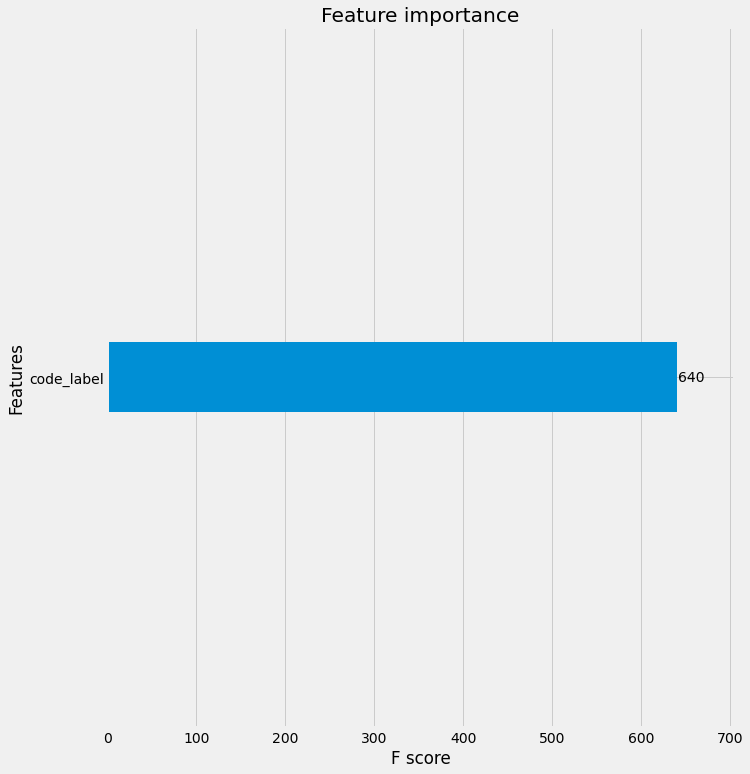

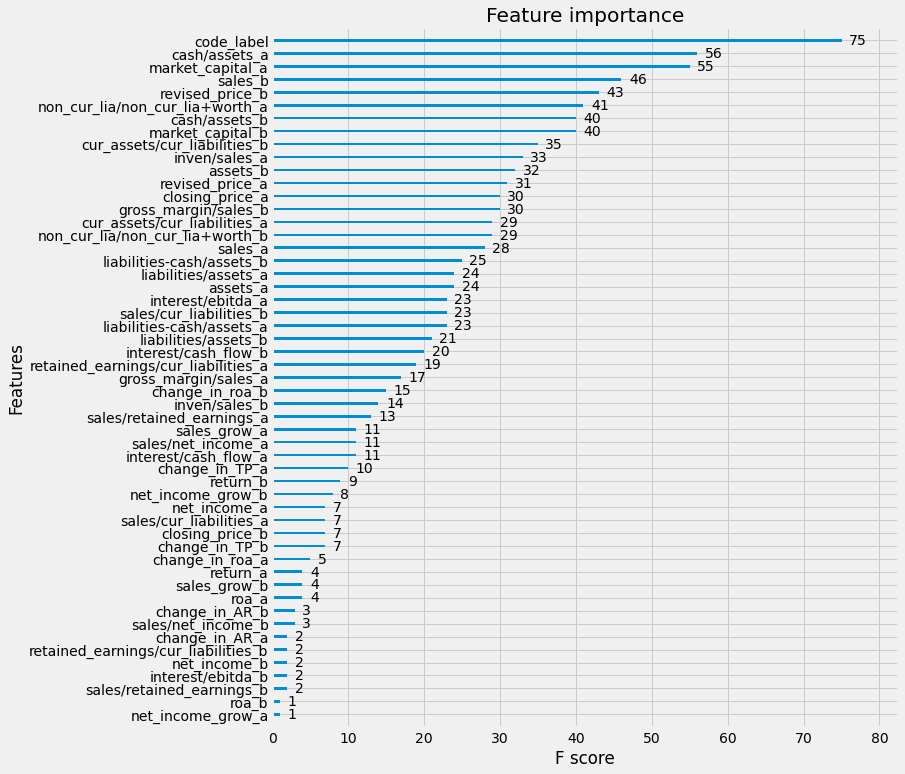

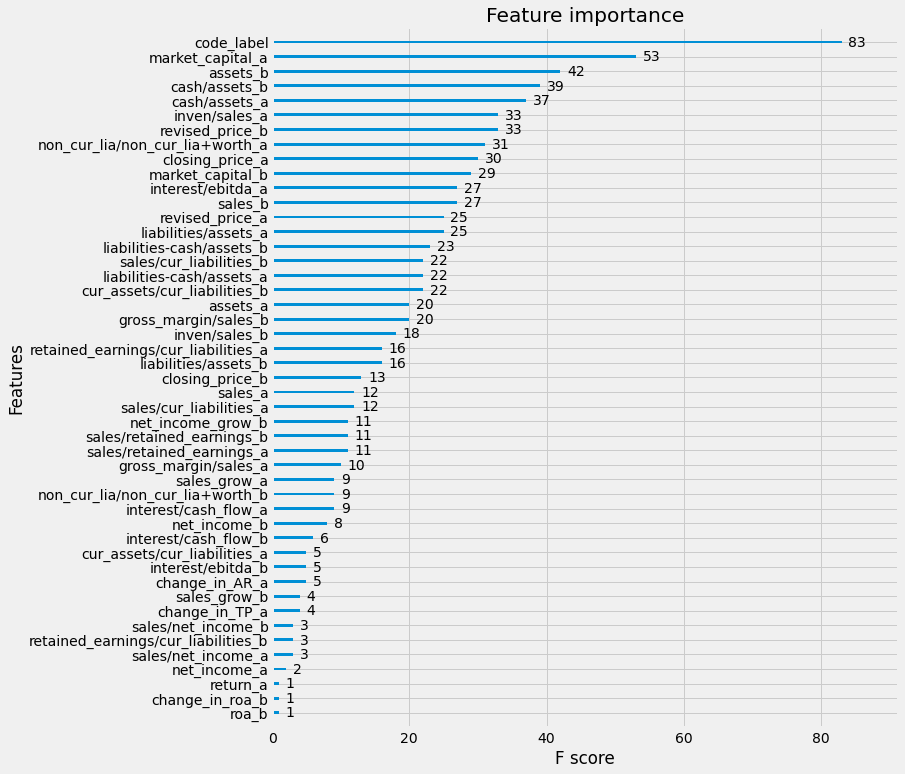

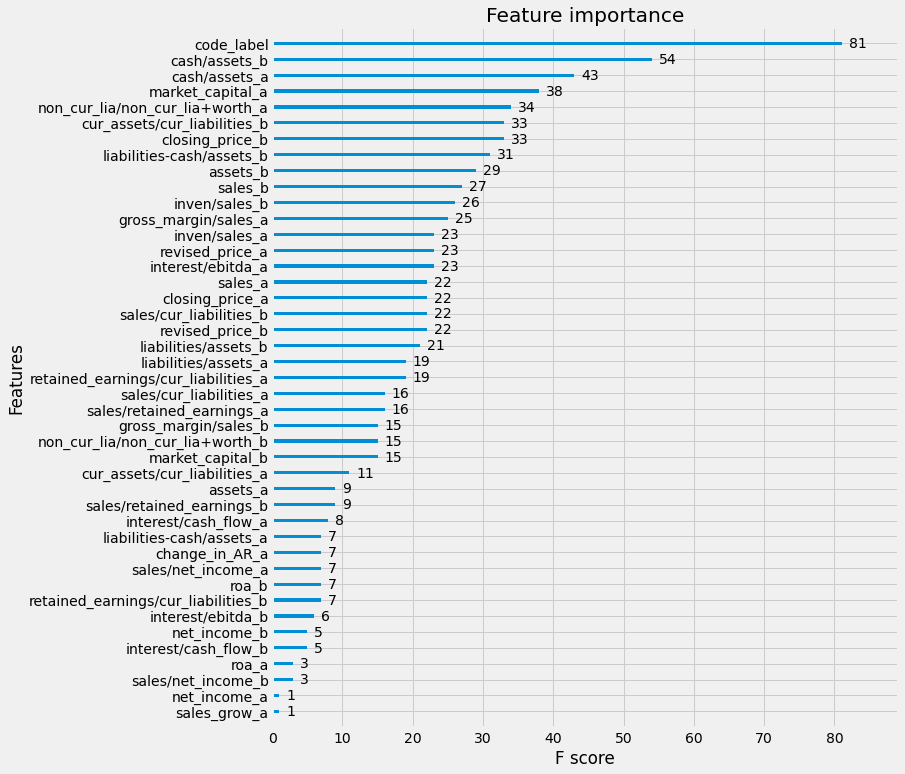

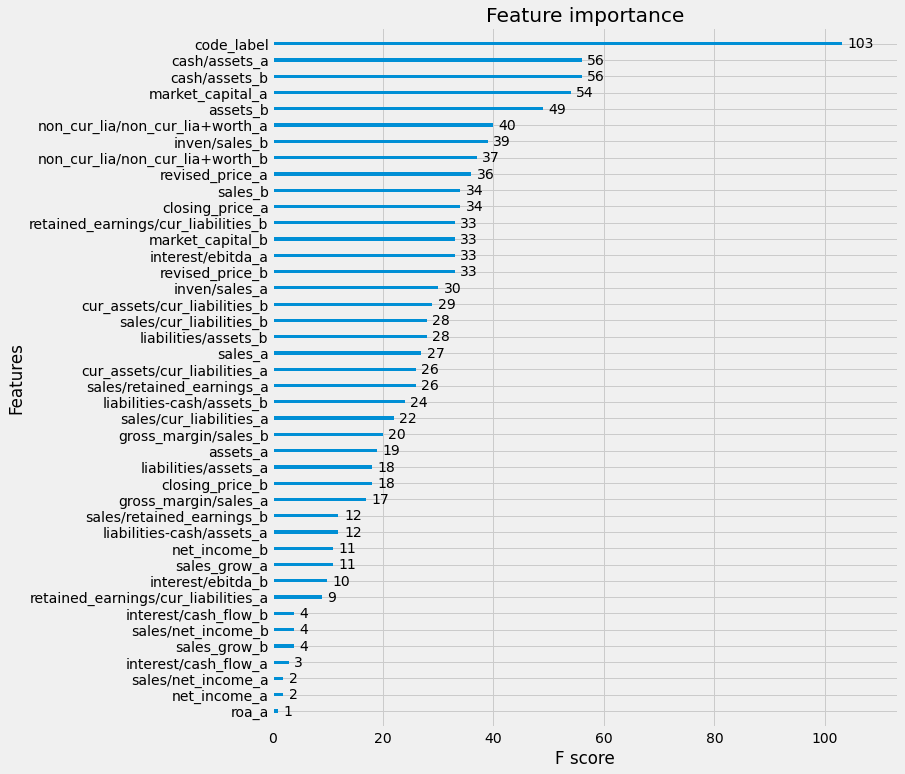

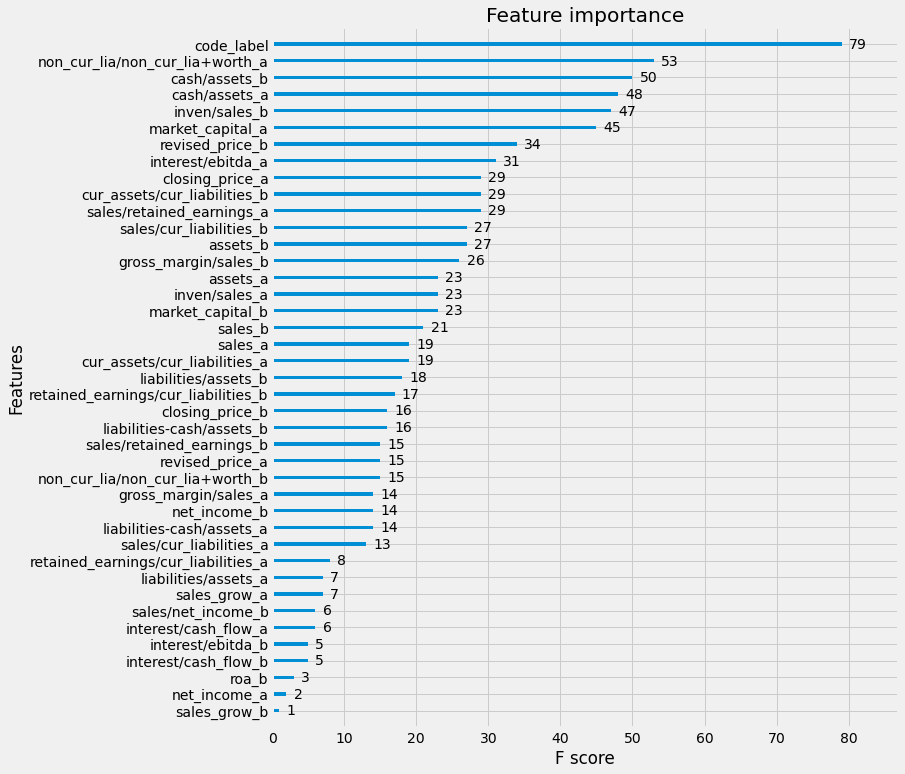

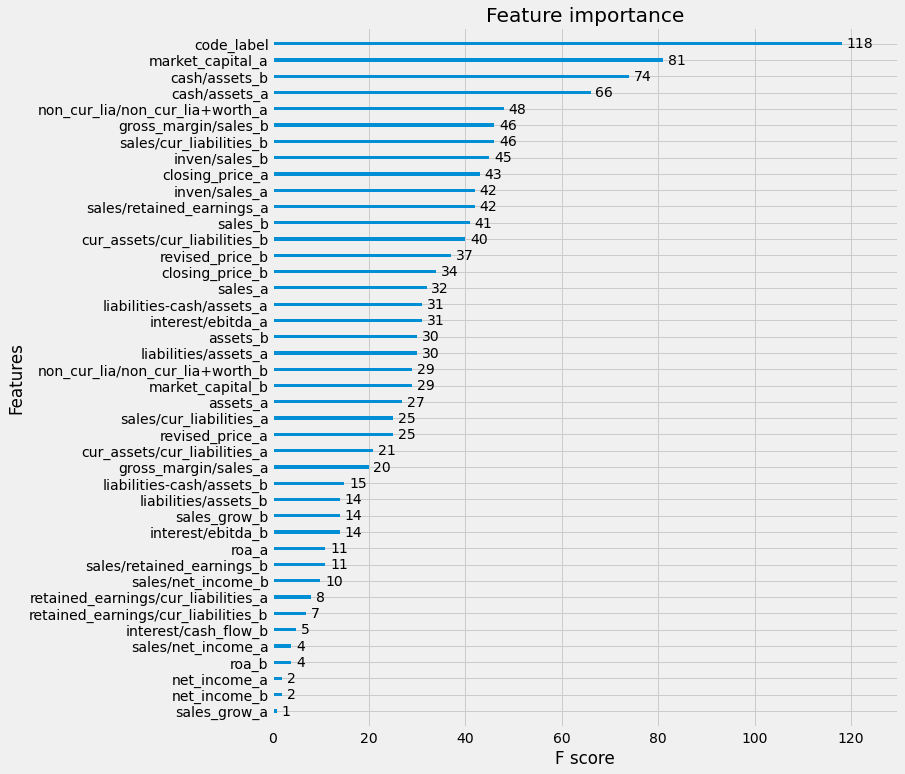

In [ ]:
result_score3_4 = pd.DataFrame()
term_list = []
score_list = []
list_0 = []
list_1 = []

for i in range(1, 8):
  term_list.append(str(i)+'년전까지')
  train_data3_4 = train_non_linear(panel_a.loc[:,'cash/assets':'fnc_rsn_unlst_year'], i)     # i = 마지막연도 재무정보 기준 n년 전
  train_data3_4

  X3_4 = train_data3_4.iloc[:,:-1]
  y3_4 = train_data3_4['fnc_rsn_unlst_year']

  result3_4 = xgb_smltn(X3_4, y3_4)
  # try:
  #   result3_4 = xgb_smltn(X3_4, y3_4)
  # except:
  #   break
  #   print("the resulting train set will be empty. 0이상 "+str(i)+"이하로 설정하세요.")

  ## 정확도
  score = accuracy_score(result3_4['y_pred'], result3_4['y_real'])
  score_list.append(round(score,4))

  ## 오답 개수
  cnt = result3_4.groupby(['y_real','y_pred'])[['y_pred']].count()
  if len(cnt.index) == 4:
    whole0_cnt = cnt.loc[('0','0'),('y_pred')] + cnt.loc[('0','1'),('y_pred')]
    wrng0_cnt = cnt.loc[('0','1'),('y_pred')]
    list_0.append(round((wrng0_cnt/whole0_cnt)*100, 3))

    whole1_cnt = cnt.loc[('1','0'),('y_pred')] + cnt.loc[('1','1'),('y_pred')]
    wrng1_cnt = cnt.loc[('1','0'),('y_pred')]
    list_1.append(round((wrng1_cnt/whole1_cnt)*100, 3))


  elif len(cnt.index) == 3: ## pred_y가 0인 값은 무조건 있으므로 (0, 1)와 (1, 1) 값이 없는 대부분
    if cnt.index.isin([('0', '1')])[1] == True: #(0, 0), (0, 1), (1, 0)
      whole0_cnt = cnt.loc[('0','0'),('y_pred')] + cnt.loc[('0','1'),('y_pred')]
      wrng0_cnt = cnt.loc[('0','1'),('y_pred')]
      list_0.append(round((wrng0_cnt/whole0_cnt)*100, 3))

      all_wrng = 1
      list_1.append(round((all_wrng)*100, 3))
    else: #(0, 0), (1, 0), (1, 1)
      all_wrng = 1
      list_0.append(round((all_wrng)*100, 3))

      whole1_cnt = cnt.loc[('1','0'),('y_pred')] + cnt.loc[('1','1'),('y_pred')]
      wrng1_cnt = cnt.loc[('1','0'),('y_pred')]
      list_1.append(round((wrng1_cnt/whole1_cnt)*100, 3))


  else: #(0, 0), (1, 0)
    all_wrng = 1
    all_crrct = 0
    list_0.append(round(all_crrct*100, 3))
    list_1.append(round(all_wrng*100, 3))

result_score3_4['term'] = term_list
result_score3_4['score'] = score_list
result_score3_4['real0_pred1(%)'] = list_0
result_score3_4['real1_pred0(%)'] = list_1

In [ ]:
result_score3_4

,term,score,real0_pred1(%),real1_pred0(%)
0,1년전까지,0.8309,0.000,100.000
1,2년전까지,0.9113,4.545,30.097
2,3년전까지,0.9146,3.953,31.068
3,4년전까지,0.9064,3.953,35.922
4,5년전까지,0.9015,4.743,34.951
5,6년전까지,0.9031,4.348,35.922
6,7년전까지,0.9064,5.336,29.126


# #4. 최적 데이터 형태 및 범위 조합한 모델

## (1) 마지막 회계결산 재무정보로만 예측 + 증가율(n=4)

In [ ]:
def train_last_grwth(df, contained_year): #주식 포함

  last_fnc_train = train_last_fnc(df).drop(['fnc_rsn_unlst_year', '코드대분류','최초상장일자', '상장일자', 'unlist_date', 'unlist_reason', 'unlist_year','unlist_reason_ctg', 'fnc_rsn_unlst', 'unlist_mon', 'unlist_last_year'], axis=1)
  train_growth_data = train_growth_rate(panel_a.loc[:,'cash/assets':'fnc_rsn_unlst_year'], contained_year)

  result = last_fnc_train.merge(train_growth_data, how='outer',on='code_label')

  return result
  
union_train1 = train_last_grwth(panel_a, 4)

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-39-70b133b319d3>:2: RuntimeWarning: divide by zero encountered in double_scalars
  rate = (p1 - p0)/p0 #증가율 계산 = (현재시점-이전시점)/(이전시점)
<ipython-input-39-70b133b319d3>:2: RuntimeWarning: invalid value encountered in double_scalars
  rate = (p1 - p0)/p0 #증가율 계산 = (현재시점-이전시점)/(이전시점)
100%|██████████| 3047/3047 [00:15<00:00, 201.56it/s]


[0]	validation_0-error:0.081967
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.081967
[2]	validation_0-error:0.080328
[3]	validation_0-error:0.081967
[4]	validation_0-error:0.081967
[5]	validation_0-error:0.080328
[6]	validation_0-error:0.080328
[7]	validation_0-error:0.080328
[8]	validation_0-error:0.077049
[9]	validation_0-error:0.07541
[10]	validation_0-error:0.07377
[11]	validation_0-error:0.070492
[12]	validation_0-error:0.072131
[13]	validation_0-error:0.072131
[14]	validation_0-error:0.072131
[15]	validation_0-error:0.072131
[16]	validation_0-error:0.072131
[17]	validation_0-error:0.072131
[18]	validation_0-error:0.07377
[19]	validation_0-error:0.07377
[20]	validation_0-error:0.07377
[21]	validation_0-error:0.07377
[22]	validation_0-error:0.07377
[23]	validation_0-error:0.07377
[24]	validation_0-error:0.07377
[25]	validation_0-error:0.07377
[26]	validation_0-error:0.07377
[27]	validation_0-error:0.072131
[28]	validation_0-error:0.0737

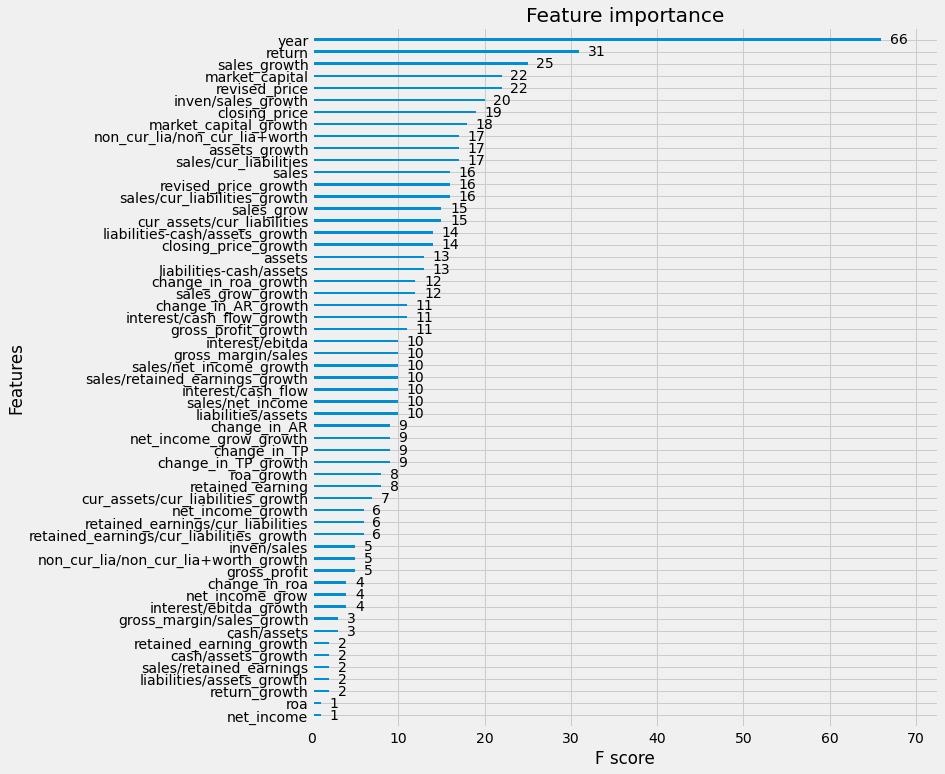

In [ ]:
X4_1 = union_train1.loc[:,'year':'return_growth']
y4_1 = union_train1['fnc_rsn_unlst_year']
union_result4_1 = xgb_smltn(X4_1, y4_1)

In [ ]:
X4_1.columns

Index(['year', 'cash/assets', 'liabilities/assets', 'liabilities-cash/assets',
       'sales/cur_liabilities', 'cur_assets/cur_liabilities',
       'retained_earnings/cur_liabilities', 'non_cur_lia/non_cur_lia+worth',
       'interest/cash_flow', 'interest/ebitda', 'inven/sales',
       'sales/net_income', 'gross_margin/sales', 'sales/retained_earnings',
       'change_in_roa', 'change_in_AR', 'change_in_TP', 'assets', 'sales',
       'roa', 'sales_grow', 'net_income', 'net_income_grow', 'gross_profit',
       'operating_profit', 'retained_earning', 'closing_price',
       'revised_price', 'market_capital', 'return', 'cash/assets_growth',
       'liabilities/assets_growth', 'liabilities-cash/assets_growth',
       'sales/cur_liabilities_growth', 'cur_assets/cur_liabilities_growth',
       'retained_earnings/cur_liabilities_growth',
       'non_cur_lia/non_cur_lia+worth_growth', 'interest/cash_flow_growth',
       'interest/ebitda_growth', 'inven/sales_growth',
       'sales/net_income_

In [ ]:
print("정확도:",accuracy_score(union_result4_1['y_pred'], union_result4_1['y_real']))

정확도: 0.9295081967213115


In [ ]:
result_count = pd.DataFrame(union_result4_1.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
print(union_result4_1.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
print('상장폐지를 상장유지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
print('상장유지를 상장폐지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

y_real  y_pred
0       0         465
        1          39
1       0           4
        1         102
Name: y_pred, dtype: int64 

상장폐지를 상장유지로 예측: 39 / 504
상장유지를 상장폐지로 예측: 4 / 106
0.0774
0.0377


## (2) 마지막 회계결산 재무정보로만 예측 + 지수함수(n=2)

In [ ]:
def train_last_non_lnr(df, contained_year):

  last_fnc_train = train_last_fnc(df).drop(['fnc_rsn_unlst_year', '코드대분류','최초상장일자', '상장일자', 'unlist_date', 'unlist_reason', 'unlist_year','unlist_reason_ctg', 'fnc_rsn_unlst', 'unlist_mon', 'unlist_last_year'], axis=1)
  train_non_linea_data = train_non_linear(panel_a.loc[:,'cash/assets':'fnc_rsn_unlst_year'], contained_year)

  result = last_fnc_train.merge(train_non_linea_data, how='outer',on='code_label')

  return result
  
union_train2 = train_last_non_lnr(panel_a, 2)

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-56-c1bea963c831>:20: RuntimeWarning: divide by zero encountered in log
  Y = np.log(y)
<ipython-input-54-77dc735660f7>:2: RuntimeWarning: invalid value encountered in double_scalars
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-54-77dc735660f7>:2: RuntimeWarning: invalid value encountered in multiply
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-56-c1bea963c831>:20: RuntimeWarning: invalid value encountered in log
  Y = np.log(y)
100%|██████████| 3047/3047 [00:15<00:00, 201.55it/s]


[0]	validation_0-error:0.085246
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.077049
[2]	validation_0-error:0.080328
[3]	validation_0-error:0.078689
[4]	validation_0-error:0.078689
[5]	validation_0-error:0.078689
[6]	validation_0-error:0.081967
[7]	validation_0-error:0.077049
[8]	validation_0-error:0.077049
[9]	validation_0-error:0.077049
[10]	validation_0-error:0.077049
[11]	validation_0-error:0.078689
[12]	validation_0-error:0.078689
[13]	validation_0-error:0.078689
[14]	validation_0-error:0.080328
[15]	validation_0-error:0.080328
[16]	validation_0-error:0.080328
[17]	validation_0-error:0.080328
[18]	validation_0-error:0.080328
[19]	validation_0-error:0.080328
[20]	validation_0-error:0.080328
[21]	validation_0-error:0.080328
[22]	validation_0-error:0.080328
[23]	validation_0-error:0.080328
[24]	validation_0-error:0.078689
[25]	validation_0-error:0.080328
[26]	validation_0-error:0.078689
[27]	validation_0-error:0.078689
[28]	validation_0-e

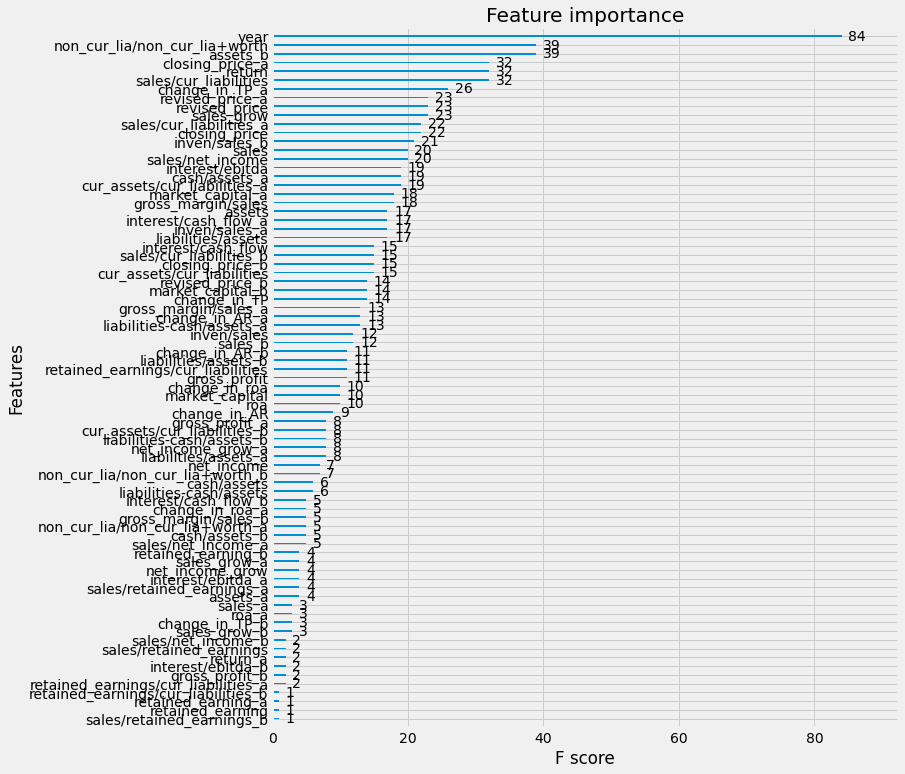

In [ ]:
X4_2 = union_train2.loc[:,'year':'return_b']
y4_2 = union_train2['fnc_rsn_unlst_year']
union_result4_2 = xgb_smltn(X4_2, y4_2)

In [ ]:
X4_2.columns

Index(['year', 'cash/assets', 'liabilities/assets', 'liabilities-cash/assets',
       'sales/cur_liabilities', 'cur_assets/cur_liabilities',
       'retained_earnings/cur_liabilities', 'non_cur_lia/non_cur_lia+worth',
       'interest/cash_flow', 'interest/ebitda', 'inven/sales',
       'sales/net_income', 'gross_margin/sales', 'sales/retained_earnings',
       'change_in_roa', 'change_in_AR', 'change_in_TP', 'assets', 'sales',
       'roa', 'sales_grow', 'net_income', 'net_income_grow', 'gross_profit',
       'operating_profit', 'retained_earning', 'closing_price',
       'revised_price', 'market_capital', 'return', 'cash/assets_a',
       'cash/assets_b', 'liabilities/assets_a', 'liabilities/assets_b',
       'liabilities-cash/assets_a', 'liabilities-cash/assets_b',
       'sales/cur_liabilities_a', 'sales/cur_liabilities_b',
       'cur_assets/cur_liabilities_a', 'cur_assets/cur_liabilities_b',
       'retained_earnings/cur_liabilities_a',
       'retained_earnings/cur_liabilities_b

In [ ]:
print("정확도:",accuracy_score(union_result4_2['y_pred'], union_result4_2['y_real']))

정확도: 0.9278688524590164


In [ ]:
result_count = pd.DataFrame(union_result4_2.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
print(union_result4_2.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
print('상장폐지를 상장유지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
print('상장유지를 상장폐지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

y_real  y_pred
0       0         466
        1          38
1       0           6
        1         100
Name: y_pred, dtype: int64 

상장폐지를 상장유지로 예측: 38 / 504
상장유지를 상장폐지로 예측: 6 / 106
0.0754
0.0566


## (3) 마지막 회계결산 재무정보로만 예측 + 증가율(n=4) + 지수함수(n=2)

In [ ]:
def train_last_grwth_non_lnr(df, contained_year1, contained_year2):

  last_fnc_train = train_last_fnc(df).drop(['fnc_rsn_unlst_year','코드대분류','최초상장일자', '상장일자', 'unlist_date', 'unlist_reason', 'unlist_year','unlist_reason_ctg', 'fnc_rsn_unlst', 'unlist_mon', 'unlist_last_year'], axis=1)
  train_growth_data = train_growth_rate(panel_a.loc[:,'cash/assets':'fnc_rsn_unlst_year'], contained_year1)
  train_non_linea_data = train_non_linear(panel_a.loc[:,'cash/assets':'fnc_rsn_unlst_year'], contained_year2)

  result = last_fnc_train.merge(train_growth_data.drop(['fnc_rsn_unlst_year'],axis=1), how='outer',on='code_label')
  result = result.merge(train_non_linea_data, how='outer',on='code_label')

  return result
  
union_train3 = train_last_grwth_non_lnr(panel_a, 4, 2)

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-39-70b133b319d3>:2: RuntimeWarning: divide by zero encountered in double_scalars
  rate = (p1 - p0)/p0 #증가율 계산 = (현재시점-이전시점)/(이전시점)
<ipython-input-39-70b133b319d3>:2: RuntimeWarning: invalid value encountered in double_scalars
  rate = (p1 - p0)/p0 #증가율 계산 = (현재시점-이전시점)/(이전시점)
  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-56-c1bea963c831>:20: RuntimeWarning: divide by zero encountered in log
  Y = np.log(y)
<ipython-input-54-77dc735660f7>:2: RuntimeWarning: invalid value encountered in multiply
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-56-c1bea963c831>:20: RuntimeWarning: invalid value encountered in log
  Y = np.log(y)
100%|██████████| 3047/3047 [00:15<00:00, 196.38it/s]


[0]	validation_0-error:0.081967
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.080328
[2]	validation_0-error:0.080328
[3]	validation_0-error:0.081967
[4]	validation_0-error:0.077049
[5]	validation_0-error:0.078689
[6]	validation_0-error:0.070492
[7]	validation_0-error:0.072131
[8]	validation_0-error:0.072131
[9]	validation_0-error:0.07377
[10]	validation_0-error:0.07377
[11]	validation_0-error:0.07377
[12]	validation_0-error:0.07377
[13]	validation_0-error:0.072131
[14]	validation_0-error:0.072131
[15]	validation_0-error:0.07377
[16]	validation_0-error:0.072131
[17]	validation_0-error:0.070492
[18]	validation_0-error:0.072131
[19]	validation_0-error:0.072131
[20]	validation_0-error:0.072131
[21]	validation_0-error:0.072131
[22]	validation_0-error:0.070492
[23]	validation_0-error:0.070492
[24]	validation_0-error:0.070492
[25]	validation_0-error:0.070492
[26]	validation_0-error:0.070492
[27]	validation_0-error:0.070492
[28]	validation_0-error:

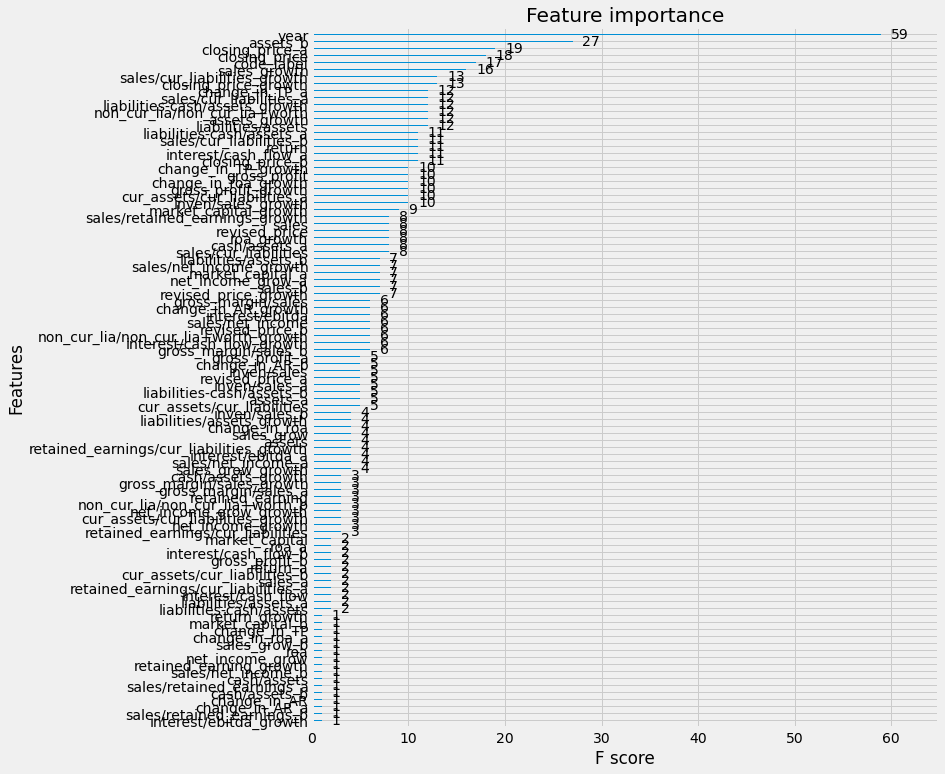

In [ ]:
union_X3 = union_train3.loc[:,'year':'return_b']
union_y3 = union_train3['fnc_rsn_unlst_year']

union_result3 = xgb_smltn(union_X3, union_y3)

In [ ]:
union_X3.columns

Index(['year', 'cash/assets', 'liabilities/assets', 'liabilities-cash/assets',
       'sales/cur_liabilities', 'cur_assets/cur_liabilities',
       'retained_earnings/cur_liabilities', 'non_cur_lia/non_cur_lia+worth',
       'interest/cash_flow', 'interest/ebitda',
       ...
       'retained_earning_a', 'retained_earning_b', 'closing_price_a',
       'closing_price_b', 'revised_price_a', 'revised_price_b',
       'market_capital_a', 'market_capital_b', 'return_a', 'return_b'],
      dtype='object', length=118)

In [ ]:
print("정확도:",accuracy_score(union_result3['y_pred'], union_result3['y_real']))

정확도: 0.9295081967213115


In [ ]:
result_count = pd.DataFrame(union_result3.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
print(union_result3.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
print('상장폐지를 상장유지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
print('상장유지를 상장폐지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

y_real  y_pred
0       0         465
        1          39
1       0           4
        1         102
Name: y_pred, dtype: int64 

상장폐지를 상장유지로 예측: 39 / 504
상장유지를 상장폐지로 예측: 4 / 106
0.0774
0.0377


## (4) 마지막 회계결산 재무정보로만 예측 + row로 나열(n=2) + 증가율(n=4) + 지수함수(n=2)

In [ ]:
def train_last_row_grwth_non_lnr(df, contained_year1, contained_year2, contained_year3):

  train_last_fnc_data = train_last_fnc(df)[['year', 'code_label']]
  train_row_data = train_row_to_col(panel_a.loc[:,'year':'fnc_rsn_unlst_year'], contained_year2).drop(['fnc_rsn_unlst_year'], axis=1)
  train_growth_data = train_growth_rate(panel_a.loc[:,'cash/assets':'fnc_rsn_unlst_year'], contained_year2).drop(['fnc_rsn_unlst_year'], axis=1)
  train_non_linea_data = train_non_linear(panel_a.loc[:,'cash/assets':'fnc_rsn_unlst_year'], contained_year3)

  result = train_last_fnc_data.merge(train_row_data, how='outer',on='code_label')
  result = result.merge(train_growth_data, how='outer',on='code_label')
  result = result.merge(train_non_linea_data, how='outer',on='code_label')

  return result
  
union_train4 = train_last_row_grwth_non_lnr(panel_a, 1, 4, 2)

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-39-70b133b319d3>:2: RuntimeWarning: divide by zero encountered in double_scalars
  rate = (p1 - p0)/p0 #증가율 계산 = (현재시점-이전시점)/(이전시점)
<ipython-input-39-70b133b319d3>:2: RuntimeWarning: invalid value encountered in double_scalars
  rate = (p1 - p0)/p0 #증가율 계산 = (현재시점-이전시점)/(이전시점)
  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-56-c1bea963c831>:20: RuntimeWarning: divide by zero encountered in log
  Y = np.log(y)
<ipython-input-54-77dc735660f7>:2: RuntimeWarning: invalid value encountered in multiply
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-56-c1bea963c831>:20: RuntimeWarning: invalid value encountered in log
  Y = np.log(y)
100%|██████████| 3047/3047 [00:15<00:00, 201.68it/s]


In [ ]:
union_result4

,year,cash/assets_0,liabilities/assets_0,liabilities-cash/assets_0,sales/cur_liabilities_0,cur_assets/cur_liabilities_0,retained_earnings/cur_liabilities_0,non_cur_lia/non_cur_lia+worth_0,interest/cash_flow_0,interest/ebitda_0,...,closing_price_a,closing_price_b,revised_price_a,revised_price_b,market_capital_a,market_capital_b,return_a,return_b,y_real,y_pred
6,2021,0.050447,0.590957,0.540509,1.958247,0.953581,1.344907,0.436843,0.000000,0.000000,...,192000.0,0.084839,118000.0,0.564447,46662441.0,0.088247,59.34,-1.902866,0,0
1677,2021,0.024978,0.253018,0.228040,3.642169,3.068167,3.332569,0.117595,0.039408,0.052709,...,32400.0,0.055528,40400.0,-0.228417,71280.0,0.055528,NaN,NaN,0,0
1498,2021,0.147312,0.575388,0.428076,2.790756,1.271135,0.451871,0.202786,0.103884,0.107330,...,310.0,2.302585,17550.0,-1.733652,9342.0,0.690897,NaN,NaN,0,0
1819,2021,0.024505,0.699270,0.674766,1.957935,0.809135,0.413354,0.354368,0.225040,0.181923,...,5770.0,0.087878,4810.0,0.224390,75982.0,0.087874,NaN,NaN,0,0
1866,2021,0.240386,0.390067,0.149681,6.350544,1.845521,1.208439,0.090575,0.013137,0.010386,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,2014,0.118965,0.910698,0.791733,1.275382,1.054445,-0.025000,0.783295,-0.846693,-0.825398,...,4660.0,-1.373501,3030.0,0.431525,34440.0,-1.364353,NaN,NaN,1,1
1881,2021,0.022307,0.548609,0.526302,3.666172,1.927448,1.072266,0.336797,0.080062,0.070275,...,29850.0,-0.415566,28500.0,0.027683,194025.0,-0.415566,NaN,NaN,0,0
1234,2021,0.253551,0.764066,0.510515,1.356468,5.288019,-13.700539,0.735087,-0.076982,-0.080851,...,11250.0,-0.212094,4976.0,0.788713,204207.0,-0.204133,NaN,NaN,0,0
236,2021,0.093949,0.194900,0.100950,9.619231,3.269620,4.579726,0.064770,0.014112,0.012212,...,121500.0,0.515752,58100.0,0.839399,603855.0,0.515752,113.16,-0.516823,0,0


[0]	validation_0-error:0.078689
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.077049
[2]	validation_0-error:0.077049
[3]	validation_0-error:0.078689
[4]	validation_0-error:0.07377
[5]	validation_0-error:0.07541
[6]	validation_0-error:0.07541
[7]	validation_0-error:0.07541
[8]	validation_0-error:0.070492
[9]	validation_0-error:0.070492
[10]	validation_0-error:0.072131
[11]	validation_0-error:0.072131
[12]	validation_0-error:0.07377
[13]	validation_0-error:0.070492
[14]	validation_0-error:0.07377
[15]	validation_0-error:0.070492
[16]	validation_0-error:0.07377
[17]	validation_0-error:0.07377
[18]	validation_0-error:0.070492
[19]	validation_0-error:0.072131
[20]	validation_0-error:0.068852
[21]	validation_0-error:0.070492
[22]	validation_0-error:0.070492
[23]	validation_0-error:0.070492
[24]	validation_0-error:0.070492
[25]	validation_0-error:0.070492
[26]	validation_0-error:0.070492
[27]	validation_0-error:0.070492
[28]	validation_0-error:0.0

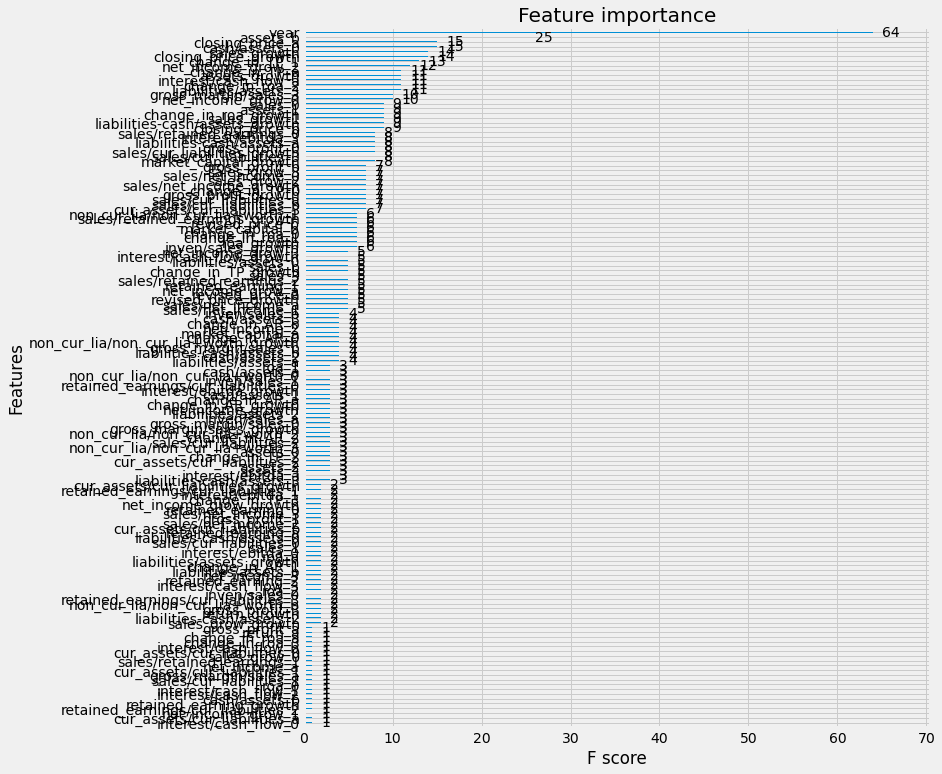

In [ ]:
union_X4 = union_train4.loc[:,'year':'return_b'].drop(['code_label'], axis=1)
union_y4 = union_train4['fnc_rsn_unlst_year']

union_result4 = xgb_smltn(union_X4, union_y4)

In [ ]:
union_X4.columns

Index(['year', 'cash/assets_0', 'liabilities/assets_0',
       'liabilities-cash/assets_0', 'sales/cur_liabilities_0',
       'cur_assets/cur_liabilities_0', 'retained_earnings/cur_liabilities_0',
       'non_cur_lia/non_cur_lia+worth_0', 'interest/cash_flow_0',
       'interest/ebitda_0',
       ...
       'retained_earning_a', 'retained_earning_b', 'closing_price_a',
       'closing_price_b', 'revised_price_a', 'revised_price_b',
       'market_capital_a', 'market_capital_b', 'return_a', 'return_b'],
      dtype='object', length=188)

In [ ]:
print("정확도:",accuracy_score(union_result4['y_pred'], union_result4['y_real']))

정확도: 0.9311475409836065


In [ ]:
result_count = pd.DataFrame(union_result4.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
print(union_result4.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
print('상장폐지를 상장유지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
print('상장유지를 상장폐지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

y_real  y_pred
0       0         465
        1          39
1       0           3
        1         103
Name: y_pred, dtype: int64 

상장폐지를 상장유지로 예측: 39 / 504
상장유지를 상장폐지로 예측: 3 / 106
0.0774
0.0283


# 주식유무 mix

## (1)

In [ ]:
def without_stock(df):
  X = df.loc[:,'cash/assets':'retained_earning']
  # X['year'] = df['year']
  # X['code_label'] = df['code_label']
  X['fnc_rsn_unlst_year'] = df['fnc_rsn_unlst_year']

  return X

panel_a_without_stock = without_stock(panel_a)

In [ ]:
def train_last_fnc_non_linear(df, contained_year):
  df_with_stock = df.loc[:,'year':'code_label']
  df_without_stock = without_stock(df).drop(['year'], axis=1)

  df_last_fnc = train_last_fnc(df_with_stock)
  df_non_linear = train_non_linear(df_without_stock, contained_year)

  optm_df = df_last_fnc.merge(df_non_linear, how='outer',on='code_label')

  return optm_df

union_train1 = train_last_fnc_non_linear(panel_a, 3)

  0%|          | 0/26 [00:00<?, ?it/s]<ipython-input-56-c1bea963c831>:20: RuntimeWarning: divide by zero encountered in log
  Y = np.log(y)
<ipython-input-54-77dc735660f7>:2: RuntimeWarning: invalid value encountered in multiply
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-54-77dc735660f7>:2: RuntimeWarning: invalid value encountered in double_scalars
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-56-c1bea963c831>:20: RuntimeWarning: invalid value encountered in log
  Y = np.log(y)
100%|██████████| 3047/3047 [00:15<00:00, 195.46it/s]


In [ ]:
union_X1 = union_train1.loc[:,'year':'retained_earning_b']
union_y1 = union_train1['fnc_rsn_unlst_year']

union_result1 = xgb_smltn(union_X1, union_y1)

In [ ]:
print("정확도:",accuracy_score(union_result1['y_pred'], union_result1['y_real']))

정확도: 0.9311475409836065


In [ ]:
result_count = pd.DataFrame(union_result1.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
print(union_result1.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
print('상장폐지를 상장유지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
print('상장유지를 상장폐지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

y_real  y_pred
0       0         466
        1          38
1       0           4
        1         102
Name: y_pred, dtype: int64 

상장폐지를 상장유지로 예측: 38 / 504
상장유지를 상장폐지로 예측: 4 / 106
0.0754
0.0377


# #4. 교차 검증

## (3) 원데이터: 직전 연도 재무정보로 다음 해 상장폐지 예측 (연도 별O)

In [ ]:
def cv_var1(df):
  df['year'] = df['year'].astype(int)
  df = df.sort_values(by='year').set_index('year')
  return df

In [ ]:
def xgb_model(X_train, y_train, X_val, y_val):
  model = XGBClassifier(n_estimators=500, early_stopping_rounds=1, max_depth=3)
  xgb_model = model.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_val, y_val)])
  return xgb_model

In [ ]:
def cv_xgb_prediction(df, test_start_year):

  result = pd.DataFrame(columns=df.loc[:,'cash/assets':'code_label'].columns)
  real_y_lst = []
  pred_y_lst = []
  pred_score_lst = [] 
  pred_vlus_lst = [] 

  df_train = df[df.index < int(test_start_year)] # 학습데이터
  window = len(set(df_train.index)) # 윈도우 사이즈 설정 (2002~2015)

  df_test = df[df.index >= int(test_start_year)] #검증데이터

  start_index = 1990

  # fit the model and make a forecast
  for year in tqdm(list(set(df_test.index))): #연도 별

      end_index = start_index + window 
      new_data = df.loc[start_index : end_index] # df에서 end_index+1

      x_train = new_data.loc[:(end_index-1),'cash/assets':'code_label']
      x_val = new_data.loc[(end_index-1),'cash/assets':'code_label'] #test set연도 이전연도

      y_train = new_data.loc[:(end_index-1),"fnc_rsn_unlst_year"]
      y_val = new_data.loc[(end_index-1),"fnc_rsn_unlst_year"] #test set연도의 이전연도
      # x_train, x_val, y_train, y_val = train_test_split(new_data.loc[:,'cash/assets':'retained_earning'], new_data["unlist_year"] ,test_size = 0.25, shuffle = False)

      # gets the trained xgb model with given data
      model = xgb_model(x_train, y_train, x_val, y_val) 

      x_new = df.loc[end_index] #test set
      x_new = pd.DataFrame(x_new).loc[:,'cash/assets':'code_label']

      y_pred = model.predict(x_new)
      y_pred_probs = model.predict_proba(x_new)

      result = pd.concat([result,x_new], axis=0)
      pred_y_lst.extend(y_pred)
      pred_score_lst.extend(y_pred_probs[:,0])
      pred_vlus_lst.extend(y_pred_probs[:,1])

      start_index = start_index + 1 # for rolling-window forecasts

      # window = window + 1 # for recursive forecasts
  result['y'] = df.loc[test_start_year:,'fnc_rsn_unlst_year']
  result['pred_y'] = pred_y_lst
  result['pred_y'] = pred_y_lst
  result['pred_score'] = pred_score_lst
  result['pred_vlus'] = pred_vlus_lst

  return result

In [ ]:
panel_a_2 = cv_var1(panel_a)
cv_result1 = cv_xgb_prediction(panel_a_2, 2013)

In [ ]:
print("정확도:",accuracy_score(cv_result1['pred_y'], cv_result1['y']))
cv_result1

In [ ]:
print(cv_result1.groupby(['y','pred_y'])['pred_y'].count())
print(" - 상장폐지를 상장유지로 예측: 12개","\n","- 상장유지를 상장폐지로 예측: 100개")

# etc

In [ ]:
r = re.compile(" [0-9]년")
set([row for row in panel['unlist_reason'] if r.search(row) is not None])